In [1]:
# import dependencies
import pandas as pd
from pathlib import Path
import random
from datetime import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# **Starting with Raw Data**

In [2]:
# import raw data from Kaggle https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset
raw_data = "data/retail_sales_raw_data.csv"

customer_shopping_data_df = pd.read_csv(raw_data)
customer_shopping_data_df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


# **Pulling Exchange Rates using an API**
## Author: Sarah Fawzy

In [3]:
# creating a smaller dataframe
dates_for_fx = pd.DataFrame()

# adding invoice date to the smaller dataframe and converting it to the format needed for the exchange rate API pull
dates_for_fx['Invoice Date'] = pd.to_datetime(customer_shopping_data_df['invoice_date'], dayfirst=True)
dates_for_fx['invoice_no'] = customer_shopping_data_df['invoice_no']

# grouping by unique dates to reduce the number of API calls needed
dates_for_query = dates_for_fx.groupby(['Invoice Date'])['invoice_no'].count()
dates_for_query = dates_for_query.reset_index()

# one more step to format the date for the API call
dates_for_query['Invoice Date'] = dates_for_query['Invoice Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
dates_for_query.head()

,Invoice Date,invoice_no
0,2021-01-01,105
1,2021-01-02,134
2,2021-01-03,137
3,2021-01-04,119
4,2021-01-05,120


In [ ]:
# constructing the API call using openexchangerates.org
base_url = 'https://openexchangerates.org/api/historical/'

for index, row in dates_for_query.iterrows():
    date = dates_for_query.loc[index,'Invoice Date']
    query_url = f"{base_url}{date}.json?app_id={fx_api_key}"
    fx_rates = requests.get(query_url).json()
    TRY_to_USD = fx_rates['rates']['TRY']
    dates_for_query.loc[index, 'TRY-USD fx rate'] = TRY_to_USD
    
# writing the results to a CSV for reference
dates_for_query.to_csv('data/fx_rates_by_date.csv')

In [5]:
fx_rates_data = "data/fx_rates_by_date.csv"
fx_by_date = pd.read_csv(fx_rates_data)
fx_data = fx_by_date.loc[:,['Invoice Date','TRY-USD fx rate']]
fx_data = fx_data.rename(columns={'Invoice Date':'date'})
fx_data.set_index("date", inplace=True)
fx_data.head()

,TRY-USD fx rate
date,
2021-01-01,7.439200
2021-01-02,7.439200
2021-01-03,7.441906
2021-01-04,7.427000
2021-01-05,7.390200


# **Cleaning up the raw data**
## Author: Nataliia Shevchenko

In [6]:
# creating conditions for random price generation to replace the repetitive price data in the raw pull
config_dict = [
    {
        "category": "Books",    
        "price": {              # configuration for calculating the price
            "price_segments": [("budget", 5), ("medium", 2), ("premium", 1)],  # probability of segment selection
            "price_range": {
                "budget": {                 
                    "Female": (0.5, 3),     # format: (minimum price, maximum price)
                    "Male": (0.5, 2)
                },
                "medium": {
                    "Female": (3, 5),
                    "Male": (2, 4)
                },
                "premium": {
                    "Female": (5, 10),
                    "Male": (4, 10)
                }
            },
        },
        # distribution of prices by months. Format: (month, price coefficient)
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {       # configuration for calculating the quantity. Format: (number of items in transaction, weight - a relative indicator of the probability of such a value)
            "Female": [(1, 3), (2, 1), (3, 0.5)], 
            "Male": [(1, 3), (2, 1.5), (3, 0.5), (4, 0.15), (5, 0.075)]
        },
        # distribution of quantity by months. Format: (month, transaction quantity coefficient)
        "quantity_month_coefficients": [(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.15)]
    },
    {
        "category": "Clothing",
        "price": {
            "price_segments": [("budget", 5), ("medium", 2), ("premium", 1)],
            "price_range": {
                "budget": {
                    "Female": (10, 50),
                    "Male": (5, 25)
                },
                "medium": {
                    "Female": (50, 200),
                    "Male": (25, 100)
                },
                "premium": {
                    "Female": (200, 1000),
                    "Male": (100, 750)
                }
            }
        },
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {
            "Female": [(1, 2), (2, 3), (3, 2), (4, 1), (5, 0.5), (6, 0.25), (7, 0.15), (8, 0.1), (9, 0.05), (10, 0.025)],
            "Male": [(1, 3), (2, 1.5), (3, 0.5), (4, 0.25), (5, 0.15), (6, 0.05), (7, 0.025)]
        },
        "quantity_month_coefficients": [(1, 1.25), (2, 0.75), (3, 1.15), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.5)]
    },
    {
        "category": "Cosmetics",
        "price": {
            "price_segments": [("budget", 5), ("medium", 2), ("premium", 1)],
            "price_range": {
                "budget": {
                    "Female": (5, 20),
                    "Male": (3, 10)
                },
                "medium": {
                    "Female": (20, 50),
                    "Male": (10, 30)
                },
                "premium": {
                    "Female": (50, 200),
                    "Male": (30, 75)
                }
            }
        },
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {
            "Female": [(1, 1), (2, 2), (3, 3), (4, 2), (5, 1), (6, 0.5), (7, 0.25), (8, 0.15), (9, 0.1), (10, 0.05)],
            "Male": [(1, 3), (2, 1.5), (3, 0.5), (4, 0.15), (5, 0.05)]
        },
        "quantity_month_coefficients": [(1, 1.25), (2, 0.75), (3, 1.15), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.25)]
    },
    {
        "category": "Food & Beverage",
        "price": {
            "price_segments": [("budget", 5), ("medium", 1), ("premium", 0.5)],
            "price_range": {
                "budget": {
                    "Female": (4, 12),
                    "Male": (2, 10)
                },
                "medium": {
                    "Female": (12, 25),
                    "Male": (10, 20)
                },
                "premium": {
                    "Female": (25, 100),
                    "Male": (20, 50)
                }
            }
        },
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {
            "Female": [(1, 0.15), (2, 0.25), (3, 0.5), (4, 1), (5, 3), (6, 3), (7, 3), (8, 2), (9, 1), (10, 0.5), (11, 0.25), (12, 0.15), (13, 0.1), (14, 0.05), (15, 0.025)],
            "Male": [(1, 0.5), (2, 0.5), (3, 0.05), (4, 0.025), (5, 0.05), (6, 0.25), (7, 0.5), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 2), (14, 2), (15, 3), (16, 3), (17, 3), (18, 3), (19, 3), (20, 3), (21, 1), (22, 1), (23, 0.5), (24, 0.25), (25, 0.1)]
        },
        "quantity_month_coefficients": [(1, 1.1), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 0.9), (8, 0.9), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.15)]
    },
    {
        "category": "Shoes",
        "price": {
            "price_segments": [("budget", 5), ("medium", 2), ("premium", 1)],
            "price_range": {
                "budget": {
                    "Female": (15, 50),
                    "Male": (10, 30)
                },
                "medium": {
                    "Female": (50, 150),
                    "Male": (30, 100)
                },
                "premium": {
                    "Female": (150, 500),
                    "Male": (100, 300)
                }
            }
        },
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {
            "Female": [(1, 1)],
            "Male": [(1, 1)]
        },
        "quantity_month_coefficients": [(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.0)]
    },
    {
        "category": "Souvenir",
        "price": {
            "price_segments": [("budget", 2), ("medium", 2), ("premium", 0.5)],
            "price_range": {
                "budget": {
                    "Female": (0.5, 1),
                    "Male": (0.5, 1)
                },
                "medium": {
                    "Female": (1, 3),
                    "Male": (1, 3)
                },
                "premium": {
                    "Female": (3, 10),
                    "Male": (3, 10)
                }
            }
        },
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {
            "Female": [(1, 0.15), (2, 0.25), (3, 0.5), (4, 1), (5, 3), (6, 3), (7, 3), (8, 2), (9, 1), (10, 0.5)],
            "Male": [(1, 1), (2, 1), (3, 1), (4, 0.5), (5, 0.5), (6, 0.25), (7, 0.25), (8, 0.1), (9, 0.05), (10, 0.025)]
        },
        "quantity_month_coefficients": [(1, 1.25), (2, 0.75), (3, 1.15), (4, 1.0), (5, 1.0), (6, 1.15), (7, 1.5), (8, 2.0), (9, 1.15), (10, 1.0), (11, 1.0), (12, 1.25)]
    },
    {
        "category": "Technology",
        "price": {
            "price_segments": [("budget", 5), ("medium", 2), ("premium", 1)],
            "price_range": {
                "budget": {
                    "Female": (10, 50),
                    "Male": (10, 50)
                },
                "medium": {
                    "Female": (50, 500),
                    "Male": (50, 500)
                },
                "premium": {
                    "Female": (500, 2000),
                    "Male": (500, 2000)
                }
            }
        },
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {
            "Female": [(1, 2), (2, 0.5), (3, 0.05)],
            "Male": [(1, 5), (2, 3), (3, 1), (4, 0.25), (5, 0.025)]
        },
        "quantity_month_coefficients": [(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.15), (12, 1.25)]
    },
    {
        "category": "Toys",
        "price": {
            "price_segments": [("budget", 5), ("medium", 2), ("premium", 1)],
            "price_range": {
                "budget": {
                    "Female": (5, 10),
                    "Male": (5, 10)
                },
                "medium": {
                    "Female": (10, 20),
                    "Male": (10, 15)
                },
                "premium": {
                    "Female": (20, 50),
                    "Male": (15, 50)
                }
            }
        },
        "price_month_coefficients": [(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, 1.1), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 0.95), (12, 0.85)],
        "quantity": {
            "Female": [(1, 3), (2, 2), (3, 0.5)],
            "Male": [(1, 3), (2, 0.5), (3, 0.025)]
        },
        "quantity_month_coefficients": [(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.25)]
    },
]

config_df = pd.DataFrame(config_dict)
config_df.set_index("category", inplace=True)

config_df

,price,price_month_coefficients,quantity,quantity_month_coefficients
category,,,,
Books,"{'price_segments': [('budget', 5), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 3), (2, 1), (3, 0.5)], 'Male':...","[(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1..."
Clothing,"{'price_segments': [('budget', 5), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 2), (2, 3), (3, 2), (4, 1), (5...","[(1, 1.25), (2, 0.75), (3, 1.15), (4, 1.0), (5..."
Cosmetics,"{'price_segments': [('budget', 5), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 1), (2, 2), (3, 3), (4, 2), (5...","[(1, 1.25), (2, 0.75), (3, 1.15), (4, 1.0), (5..."
Food & Beverage,"{'price_segments': [('budget', 5), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 0.15), (2, 0.25), (3, 0.5), (4...","[(1, 1.1), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1..."
Shoes,"{'price_segments': [('budget', 5), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 1)], 'Male': [(1, 1)]}","[(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1..."
Souvenir,"{'price_segments': [('budget', 2), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 0.15), (2, 0.25), (3, 0.5), (4...","[(1, 1.25), (2, 0.75), (3, 1.15), (4, 1.0), (5..."
Technology,"{'price_segments': [('budget', 5), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 2), (2, 0.5), (3, 0.05)], 'Mal...","[(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1..."
Toys,"{'price_segments': [('budget', 5), ('medium', ...","[(1, 1.0), (2, 1.2), (3, 1.15), (4, 1.1), (5, ...","{'Female': [(1, 3), (2, 2), (3, 0.5)], 'Male':...","[(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1..."


In [7]:
# generating random price data
def calculate_random_price_quantity(category, gender, invoice_date, quantity):
    # convert date
    date = datetime.strptime(invoice_date, "%d/%m/%Y").strftime("%Y-%m-%d")
    month = datetime.strptime(invoice_date, "%d/%m/%Y").month

    # read configuration
    price_segment_weights_list = config_df.loc[category]["price"]["price_segments"]
    price_month_coefficient = config_df.loc[category]["price_month_coefficients"][month - 1][1]

    quantity_weights_list = config_df.loc[category]["quantity"][gender]
    quantity_base_month_coefficient = config_df.loc[category]["quantity_month_coefficients"][month - 1][1]

    # process configuration
    price_segment_list = [x[0] for x in price_segment_weights_list]
    price_segment_weights = [x[1] for x in price_segment_weights_list]

    price_segment = random.choices(price_segment_list, weights=price_segment_weights, k=1)[0]

    min_price = config_df.loc[category]["price"]["price_range"][price_segment][gender][0]
    max_price = config_df.loc[category]["price"]["price_range"][price_segment][gender][1]

    quantity_list = [x[0] for x in quantity_weights_list]
    quantity_weights = [x[1] for x in quantity_weights_list]

    # get exchange rate
    exchange_rate = fx_data.loc[date][0]

    # calculate random price
    exchange_rate_random_coefficient = random.uniform(0.9, 1.1)

    base_random_price = random.uniform(min_price, max_price)

    random_price = round(base_random_price * price_month_coefficient * exchange_rate * exchange_rate_random_coefficient, 2)

    # calculate random quantity
    # exeption is Shoes category, keep the original quantity
    if category != "Shoes":
        base_random_quantity = random.choices(quantity_list, weights=quantity_weights, k=1)[0]

        random_quantity = round(base_random_quantity * quantity_base_month_coefficient)

        if random_quantity == 0:
            random_quantity = 1
    else:
        random_quantity = quantity

    return random_price, random_quantity

In [9]:
# writing new random data to a "clean" df
customer_shopping_data_df[["random_price", "random_quantity"]] = \
    customer_shopping_data_df.apply(lambda row: pd.Series(calculate_random_price_quantity(category=row["category"], 
                                                                                          gender=row["gender"],
                                                                                          invoice_date=row["invoice_date"],
                                                                                          quantity=row["quantity"])), axis=1)

customer_shopping_data_df.head()

C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\3179719168.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exchange_rate = fx_data.loc[date][0]


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,random_price,random_quantity
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon,289.93,2.0
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul,370.28,3.0
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity,172.01,2.0
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM,356.53,5.0
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon,10.96,1.0


In [11]:
# converting the reandom quantity to an integer
customer_shopping_data_df["random_quantity"] = customer_shopping_data_df["random_quantity"].astype(int)
customer_shopping_data_df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,random_price,random_quantity
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon,289.93,2
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul,370.28,3
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity,172.01,2
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM,356.53,5
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon,10.96,1


In [12]:
# cleaning up the dataframe
customer_shopping_data_df.drop(columns=["quantity", "price"], inplace=True)
customer_shopping_data_df.rename(columns={"random_price": "price", "random_quantity": "quantity"}, inplace=True)

customer_shopping_data_df = customer_shopping_data_df[["invoice_no", "customer_id", "gender", "age", "category", "quantity", "price", "payment_method", "invoice_date", "shopping_mall"]]

customer_shopping_data_df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,370.28,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,2,172.01,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,356.53,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,1,10.96,Cash,24/10/2021,Kanyon


In [13]:
# writing the newly generated data to a csv
customer_shopping_data_df.to_csv("data/customer_shopping_data_clean.csv", header=True, index=False)

# **Merge FX data with clean shopping data**
## Author: Sarah Fawzy

In [14]:
# organizing the fx data in a way that can be merged with the customer shopping data to calculate USD price
fx_by_date = fx_by_date.loc[:,['Invoice Date','TRY-USD fx rate']]
fx_by_date['Invoice Date'] = pd.to_datetime(fx_by_date["Invoice Date"])
fx_by_date['Invoice Date'] = fx_by_date['Invoice Date'].dt.strftime("%Y-%m-%d")
fx_by_date.head()

,Invoice Date,TRY-USD fx rate
0,2021-01-01,7.439200
1,2021-01-02,7.439200
2,2021-01-03,7.441906
3,2021-01-04,7.427000
4,2021-01-05,7.390200


In [15]:
clean_data = 'data/customer_shopping_data_clean.csv'
retail_clean_data = pd.read_csv(clean_data)

In [16]:
# creating a smaller dataframe to write USD prices to so the base dataframe can remain untouched
clean_small = pd.DataFrame()

clean_small['Invoice Date'] = pd.to_datetime(retail_clean_data['invoice_date'], dayfirst=True)
clean_small['TRY Price'] = retail_clean_data['price']
clean_small['invoice_no'] = retail_clean_data['invoice_no']
clean_small['Invoice Date'] = clean_small['Invoice Date'].dt.strftime("%Y-%m-%d")
clean_small.head()

,Invoice Date,TRY Price,invoice_no
0,2022-08-05,289.93,I138884
1,2021-12-12,370.28,I317333
2,2021-11-09,172.01,I127801
3,2021-05-16,356.53,I173702
4,2021-10-24,10.96,I337046


In [17]:
# merging the fx data with the smaller dataframe
usd_rates = clean_small.merge(fx_by_date,how='outer',on='Invoice Date')

usd_rates.head()

,Invoice Date,TRY Price,invoice_no,TRY-USD fx rate
0,2022-08-05,289.93,I138884,17.9126
1,2022-08-05,134.76,I730771,17.9126
2,2022-08-05,127.27,I321373,17.9126
3,2022-08-05,363.87,I295337,17.9126
4,2022-08-05,149.69,I419999,17.9126


In [18]:
# calculating the price in USD and writing the new data to a csv
usd_rates['USD Price'] = usd_rates['TRY Price']/usd_rates['TRY-USD fx rate']
usd_rates.head()
usd_rates.to_csv('data/Prices_in_USD.csv')
usd_rates.head()

,Invoice Date,TRY Price,invoice_no,TRY-USD fx rate,USD Price
0,2022-08-05,289.93,I138884,17.9126,16.185813
1,2022-08-05,134.76,I730771,17.9126,7.523196
2,2022-08-05,127.27,I321373,17.9126,7.105055
3,2022-08-05,363.87,I295337,17.9126,20.313634
4,2022-08-05,149.69,I419999,17.9126,8.356687


# **Importing weather data using an API**
## Authors: Natalia Belyaeva and Sarah Fawzy

In [93]:
# latitude and longitude for each mall (10 in total) were found using https://www.latlong.net/
lat_lon = 'data/lat_and_lon.csv'
lat_lon_df = pd.read_csv(lat_lon)
lat_lon_df.rename
lat_lon_df.head()

,Unnamed: 0,shopping_mall,Latitude,Longitude,invoice_no
0,0,Cevahir AVM,41.063229,28.993401,4991
1,1,Emaar Square Mall,41.004342,29.071038,4811
2,2,Forum Istanbul,41.047664,28.896845,4947
3,3,Istinye Park,41.110507,29.033252,9781
4,4,Kanyon,41.078039,29.010781,19823


In [21]:
# merging latitude and longitude with original clean dataframe and creating Invoice Data column for API pull
mall_data = customer_shopping_data_df.merge(lat_lon_df, how='outer', on= 'shopping_mall')
mall_data = mall_data.drop(columns = ['Unnamed: 0','invoice_no_y'])
mall_data['Invoice Date'] = pd.to_datetime(mall_data['invoice_date'], dayfirst=True)
mall_data.head()

,invoice_no_x,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Latitude,Longitude,Invoice Date
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,5/8/2022,Kanyon,41.078039,29.010781,2022-08-05
1,I337046,C189076,Female,53,Books,1,10.96,Cash,24/10/2021,Kanyon,41.078039,29.010781,2021-10-24
2,I326945,C283361,Female,60,Clothing,3,345.93,Credit Card,22/08/2021,Kanyon,41.078039,29.010781,2021-08-22
3,I336189,C555402,Female,67,Clothing,2,351.85,Credit Card,3/6/2022,Kanyon,41.078039,29.010781,2022-06-03
4,I252275,C313348,Male,44,Technology,1,347.55,Cash,26/10/2021,Kanyon,41.078039,29.010781,2021-10-26


In [22]:
# since there are too many records to run through the API, we are taking the mid-point of every month to approximate the average weather for the entire month
mall_data['Month'] = mall_data['Invoice Date'].dt.strftime("%Y-%m")
mall_data['date for query'] = mall_data['Month']+'-15'
mall_data.head()

,invoice_no_x,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Latitude,Longitude,Invoice Date,Month,date for query
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,5/8/2022,Kanyon,41.078039,29.010781,2022-08-05,2022-08,2022-08-15
1,I337046,C189076,Female,53,Books,1,10.96,Cash,24/10/2021,Kanyon,41.078039,29.010781,2021-10-24,2021-10,2021-10-15
2,I326945,C283361,Female,60,Clothing,3,345.93,Credit Card,22/08/2021,Kanyon,41.078039,29.010781,2021-08-22,2021-08,2021-08-15
3,I336189,C555402,Female,67,Clothing,2,351.85,Credit Card,3/6/2022,Kanyon,41.078039,29.010781,2022-06-03,2022-06,2022-06-15
4,I252275,C313348,Male,44,Technology,1,347.55,Cash,26/10/2021,Kanyon,41.078039,29.010781,2021-10-26,2021-10,2021-10-15


In [23]:
# grouped the dataframe by mall and 'date for query' (month_midpoint) to reduce the number of API pulls needed
mall_data = mall_data.rename(columns={"Latitude ":'Latitude','Longitude ':'Longitude','invoice_no_x':'invoice_no'})
by_mall = mall_data.groupby(['shopping_mall','date for query','Latitude','Longitude'])['invoice_no'].count()
by_mall = by_mall.reset_index()
by_mall.head()

,shopping_mall,date for query,Latitude,Longitude,invoice_no
0,Cevahir AVM,2021-01-15,41.063229,28.993401,221
1,Cevahir AVM,2021-02-15,41.063229,28.993401,154
2,Cevahir AVM,2021-03-15,41.063229,28.993401,193
3,Cevahir AVM,2021-04-15,41.063229,28.993401,183
4,Cevahir AVM,2021-05-15,41.063229,28.993401,224


In [ ]:
# pulling weather data using an API from https://www.visualcrossing.com/ and writing to csv
base_url = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'

for index, row in by_mall.iterrows():
    date = by_mall.loc[index,'date for query']
    lat = by_mall.loc[index, 'Latitude']
    lon = by_mall.loc[index, 'Longitude']

    query_url = f"{base_url}{lat},{lon}/{date}?unitGroup=us&key={visualcrossing_api_key}"
    weather_data = requests.get(query_url).json()
    temp = weather_data['days'][0]['temp']
    by_mall.loc[index,'Temp in F'] = temp

by_mall.to_csv('data/temp in F.csv')

In [25]:
# importing the csv just written from the API
temp_in_F = 'data/temp_in_F.csv'
temperatures = pd.read_csv(temp_in_F)
temperatures.head()

,Unnamed: 0,shopping_mall,date for query,Latitude,Longitude,invoice_no,Temp in F
0,0,Cevahir AVM,2021-01-15,41.063229,28.993401,221,38.3
1,1,Cevahir AVM,2021-02-15,41.063229,28.993401,154,34.4
2,2,Cevahir AVM,2021-03-15,41.063229,28.993401,193,54.7
3,3,Cevahir AVM,2021-04-15,41.063229,28.993401,183,52.0
4,4,Cevahir AVM,2021-05-15,41.063229,28.993401,224,66.8


In [26]:
# merging temperature data with broader dataframe
temp_data = mall_data.merge(temperatures, how = 'inner', on = ('date for query', 'shopping_mall'))

temp_data.head()

,invoice_no_x,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Latitude_x,Longitude_x,Invoice Date,Month,date for query,Unnamed: 0,Latitude_y,Longitude_y,invoice_no_y,Temp in F
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,5/8/2022,Kanyon,41.078039,29.010781,2022-08-05,2022-08,2022-08-15,127,41.078039,29.010781,764,73.3
1,I289643,C584700,Female,43,Technology,1,1508.68,Cash,22/08/2022,Kanyon,41.078039,29.010781,2022-08-22,2022-08,2022-08-15,127,41.078039,29.010781,764,73.3
2,I184307,C175946,Male,22,Food & Beverage,18,91.98,Credit Card,25/08/2022,Kanyon,41.078039,29.010781,2022-08-25,2022-08,2022-08-15,127,41.078039,29.010781,764,73.3
3,I818298,C204632,Male,21,Clothing,4,132.75,Debit Card,21/08/2022,Kanyon,41.078039,29.010781,2022-08-21,2022-08,2022-08-15,127,41.078039,29.010781,764,73.3
4,I215578,C866033,Male,39,Cosmetics,1,114.65,Credit Card,4/8/2022,Kanyon,41.078039,29.010781,2022-08-04,2022-08,2022-08-15,127,41.078039,29.010781,764,73.3


In [27]:
# cleaning up the new merged dataframe
temp_data_clean = temp_data.drop(columns = ['Unnamed: 0','invoice_no_y', 'Latitude_y', 'Longitude_y'])
temp_data_clean.head()

,invoice_no_x,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Latitude_x,Longitude_x,Invoice Date,Month,date for query,Temp in F
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,5/8/2022,Kanyon,41.078039,29.010781,2022-08-05,2022-08,2022-08-15,73.3
1,I289643,C584700,Female,43,Technology,1,1508.68,Cash,22/08/2022,Kanyon,41.078039,29.010781,2022-08-22,2022-08,2022-08-15,73.3
2,I184307,C175946,Male,22,Food & Beverage,18,91.98,Credit Card,25/08/2022,Kanyon,41.078039,29.010781,2022-08-25,2022-08,2022-08-15,73.3
3,I818298,C204632,Male,21,Clothing,4,132.75,Debit Card,21/08/2022,Kanyon,41.078039,29.010781,2022-08-21,2022-08,2022-08-15,73.3
4,I215578,C866033,Male,39,Cosmetics,1,114.65,Credit Card,4/8/2022,Kanyon,41.078039,29.010781,2022-08-04,2022-08,2022-08-15,73.3


In [28]:
# further cleanup
full_data_with_temp = temp_data_clean.rename(columns={'Latitude_x':'Latitude', 'Longitude_x':'Longitude','invoice_no_x':'invoice_no'})
full_data_with_temp.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Latitude,Longitude,Invoice Date,Month,date for query,Temp in F
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,5/8/2022,Kanyon,41.078039,29.010781,2022-08-05,2022-08,2022-08-15,73.3
1,I289643,C584700,Female,43,Technology,1,1508.68,Cash,22/08/2022,Kanyon,41.078039,29.010781,2022-08-22,2022-08,2022-08-15,73.3
2,I184307,C175946,Male,22,Food & Beverage,18,91.98,Credit Card,25/08/2022,Kanyon,41.078039,29.010781,2022-08-25,2022-08,2022-08-15,73.3
3,I818298,C204632,Male,21,Clothing,4,132.75,Debit Card,21/08/2022,Kanyon,41.078039,29.010781,2022-08-21,2022-08,2022-08-15,73.3
4,I215578,C866033,Male,39,Cosmetics,1,114.65,Credit Card,4/8/2022,Kanyon,41.078039,29.010781,2022-08-04,2022-08,2022-08-15,73.3


In [29]:
# write to csv
full_data_with_temp.to_csv('data/data with temp.csv')

# **Merging all data together**
## Author: Jonathan Gonzalez Estrella
 

In [30]:
# importing the csvs and converting to dataframes to merge
full_data_path = "data/data with temp.csv"
usd_prices = "data/Prices_in_USD.csv"

full_data_df = pd.read_csv(full_data_path)
usd_prices_data_df = pd.read_csv(usd_prices)

In [31]:
# merging the dataframes
merged_df = full_data_df.merge(usd_prices_data_df[['invoice_no', 'TRY-USD fx rate', 'USD Price']], on='invoice_no', how='left')
merged_df = merged_df.drop(columns= ['Unnamed: 0', 'date for query'])
merged_df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Latitude,Longitude,Invoice Date,Month,Temp in F,TRY-USD fx rate,USD Price
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,5/8/2022,Kanyon,41.078039,29.010781,2022-08-05,2022-08,73.3,17.912600,16.185813
1,I289643,C584700,Female,43,Technology,1,1508.68,Cash,22/08/2022,Kanyon,41.078039,29.010781,2022-08-22,2022-08,73.3,18.105499,83.327170
2,I184307,C175946,Male,22,Food & Beverage,18,91.98,Credit Card,25/08/2022,Kanyon,41.078039,29.010781,2022-08-25,2022-08,73.3,18.173301,5.061271
3,I818298,C204632,Male,21,Clothing,4,132.75,Debit Card,21/08/2022,Kanyon,41.078039,29.010781,2022-08-21,2022-08,73.3,18.095979,7.335884
4,I215578,C866033,Male,39,Cosmetics,1,114.65,Credit Card,4/8/2022,Kanyon,41.078039,29.010781,2022-08-04,2022-08,73.3,17.946800,6.388325


In [32]:
# writing the merged data to csv
merged_df.to_csv('data/merged_data.csv')

# **Data Analysis**
## Author: Jonathan Gonzalez Estrella

In [33]:
# Create a table with the transactions count by gender and shopping mall
transactions_by_gender_mall = merged_df.groupby(['gender', 'shopping_mall']).size().unstack(fill_value=0)
transactions_by_gender_mall.loc['Total by Mall']= transactions_by_gender_mall.sum()
transactions_by_gender_mall['Total by Gender'] = transactions_by_gender_mall.sum(axis=1)

# Display the table
transactions_by_gender_mall

shopping_mall,Cevahir AVM,Emaar Square Mall,Forum Istanbul,Istinye Park,Kanyon,Mall of Istanbul,Metrocity,Metropol AVM,Viaport Outlet,Zorlu Center,Total by Gender
gender,,,,,,,,,,,
Female,2940,2842,3016,5874,11906,11902,8941,6144,2949,2968,59482
Male,2051,1969,1931,3907,7917,8041,6070,4017,1965,2107,39975
Total by Mall,4991,4811,4947,9781,19823,19943,15011,10161,4914,5075,99457


In [34]:
# Analyze Purchases During Bad Weather
# Add a 'bad_weather' column based on temperature
high_temp = merged_df['Temp in F'] > 90
low_temp = merged_df['Temp in F'] < 60
merged_df['bad_weather'] = high_temp | low_temp

# Group by 'bad_weather' and count unique transactions
bad_weather_purchases = merged_df.groupby('bad_weather')['invoice_no'].nunique()
bad_weather_purchases

bad_weather
False    45907
True     53550
Name: invoice_no, dtype: int64

In [35]:
# Analyze Weekend vs. Weekday Shopping
# Add a 'weekend' column
merged_df['invoice_date'] = pd.to_datetime(merged_df['invoice_date'], format='%d/%m/%Y')
merged_df['weekend'] = merged_df['invoice_date'].dt.dayofweek >= 5

# Group by 'weekend' and count unique transactions
weekend_purchases = merged_df.groupby('weekend')['invoice_no'].nunique()
weekend_purchases

weekend
False    71196
True     28261
Name: invoice_no, dtype: int64

In [36]:
# Group by 'age', 'gender', and 'category', then sum the 'USD Price' for each group
spending_by_age_gender_category = merged_df.groupby(['age', 'gender', 'category'])['USD Price'].sum().reset_index()

# To find the maximum spending category for each age and gender group
max_spending_by_age_gender = spending_by_age_gender_category.loc[spending_by_age_gender_category.groupby(['age', 'gender'])['USD Price'].idxmax()]

max_spending_by_age_gender.head()

,age,gender,category,USD Price
1,18,Female,Clothing,55503.527648
9,18,Male,Clothing,20660.921822
17,19,Female,Clothing,54152.939494
25,19,Male,Clothing,20656.855640
33,20,Female,Clothing,52393.215368


In [37]:
# Median spend by gender and by year

# First, ensure 'invoice_date' is in datetime format if not already done
merged_df['invoice_date'] = pd.to_datetime(merged_df['invoice_date'], format='%d/%m/%Y')

# Extract year from 'invoice_date'
merged_df['year'] = merged_df['invoice_date'].dt.year

# Calculate median spend by gender and year
median_spend_by_gender_year = merged_df.groupby(['gender', 'year'])['USD Price'].median().reset_index()
median_spend_by_gender_year.head()

,gender,year,USD Price
0,Female,2021,22.145029
1,Female,2022,21.835314
2,Female,2023,23.149401
3,Male,2021,13.120310
4,Male,2022,12.987595


In [38]:
# Max and min spend by gender

# Calculate maximum spend by gender and year
max_spend_by_gender_year = merged_df.groupby(['gender', 'year'])['USD Price'].max().reset_index()

# Calculate minimum spend by gender and year
min_spend_by_gender_year = merged_df.groupby(['gender', 'year'])['USD Price'].min().reset_index()

# Print the results
print("Maximum Spend by Gender and Year:")
max_spend_by_gender_year

Maximum Spend by Gender and Year:


,gender,year,USD Price
0,Female,2021,2285.667958
1,Female,2022,2556.136143
2,Female,2023,2323.973221
3,Male,2021,2220.865891
4,Male,2022,2411.553909
5,Male,2023,2374.751389


In [39]:
print("\nMinimum Spend by Gender and Year:")
min_spend_by_gender_year


Minimum Spend by Gender and Year:


,gender,year,USD Price
0,Female,2021,0.419065
1,Female,2022,0.404891
2,Female,2023,0.516132
3,Male,2021,0.426460
4,Male,2022,0.430893
5,Male,2023,0.506130


In [40]:
#  highest spending amount by year and by gender

# Group by year, gender, and shopping mall, then sum the 'USD Price' for each group
spend_by_year_gender_mall = merged_df.groupby(['year', 'gender', 'shopping_mall'])['USD Price'].sum().reset_index()

# Find the mall with the highest spending amount for each year and gender
highest_spend_mall_by_year_gender = spend_by_year_gender_mall.loc[spend_by_year_gender_mall.groupby(['year', 'gender'])['USD Price'].idxmax()]

highest_spend_mall_by_year_gender.head()

,year,gender,shopping_mall,USD Price
5,2021,Female,Mall of Istanbul,417491.769401
14,2021,Male,Kanyon,182540.254035
24,2022,Female,Kanyon,412407.709202
35,2022,Male,Mall of Istanbul,210277.525631
44,2023,Female,Kanyon,88067.310350


In [41]:
# identify the category with the lowest spending on bad weather days
bad_weather_data = merged_df[merged_df['Temp in F'] < 60]

# Aggregate spending by category for bad weather days
spending_by_category = bad_weather_data.groupby('category')['USD Price'].sum()

# Identify the category with the least spending
least_spending_category = spending_by_category.idxmin()

print(f"The category with the least spending amount on bad weather days is: {least_spending_category}")

The category with the least spending amount on bad weather days is: Souvenir


In [42]:
# dentify the category with the highest spending on bad weather days
spending_by_category_bad_weather = bad_weather_data.groupby('category')['USD Price'].sum()

# Identify the category with the highest spending
highest_spending_category_bad_weather = spending_by_category_bad_weather.idxmax()

print(f"The category with the highest spending amount on bad weather days is: {highest_spending_category_bad_weather}")

The category with the highest spending amount on bad weather days is: Clothing


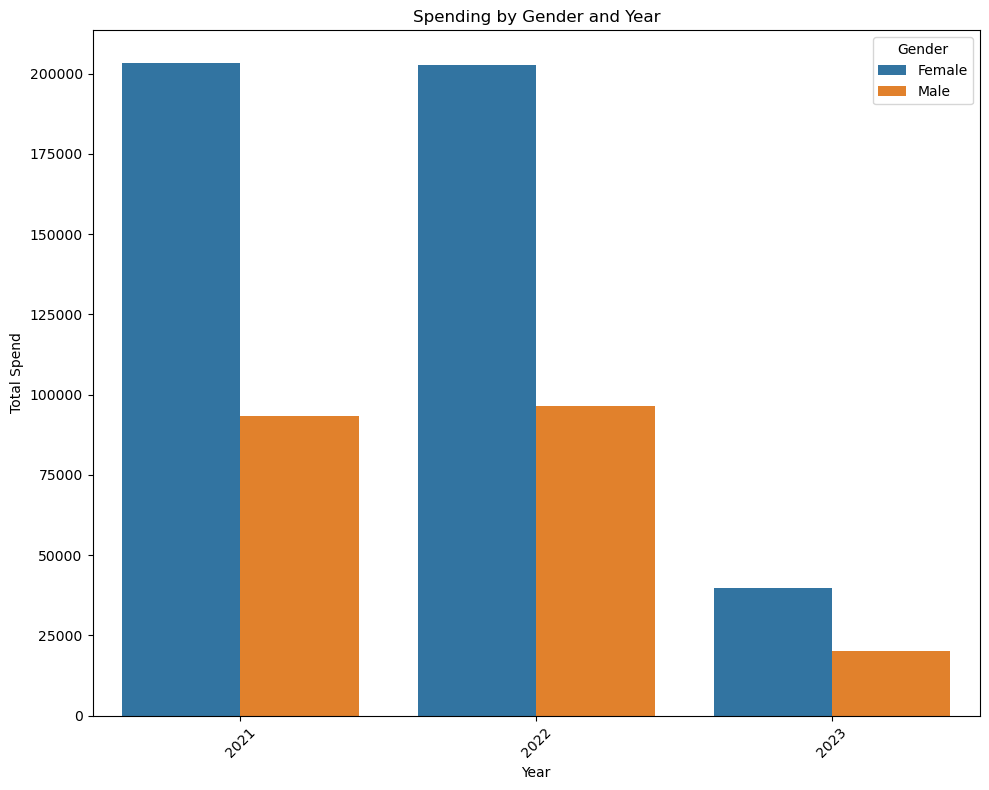

In [43]:
# pay chart that displays spending by gender and by year
spend_by_mall_gender_year = merged_df.groupby(['shopping_mall', 'gender', 'year'])['USD Price'].sum().reset_index()
pivot_table = spend_by_mall_gender_year.pivot_table(values='USD Price', index=['shopping_mall', 'year'], columns='gender', aggfunc='sum').reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x='year', y='USD Price', hue='gender', data=spend_by_mall_gender_year, errorbar=None)
plt.title('Spending by Gender and Year')
plt.xticks(rotation=45)
plt.ylabel('Total Spend')
plt.xlabel('Year')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

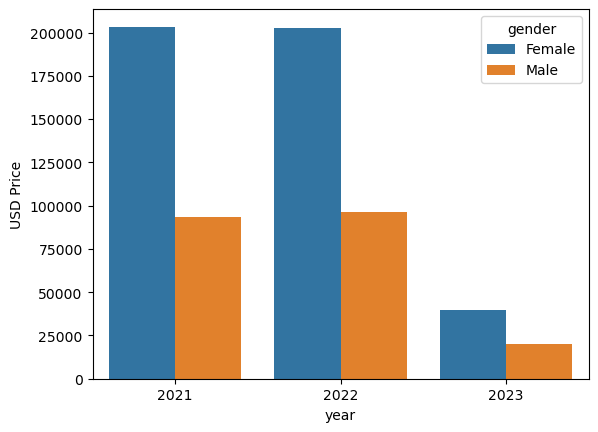

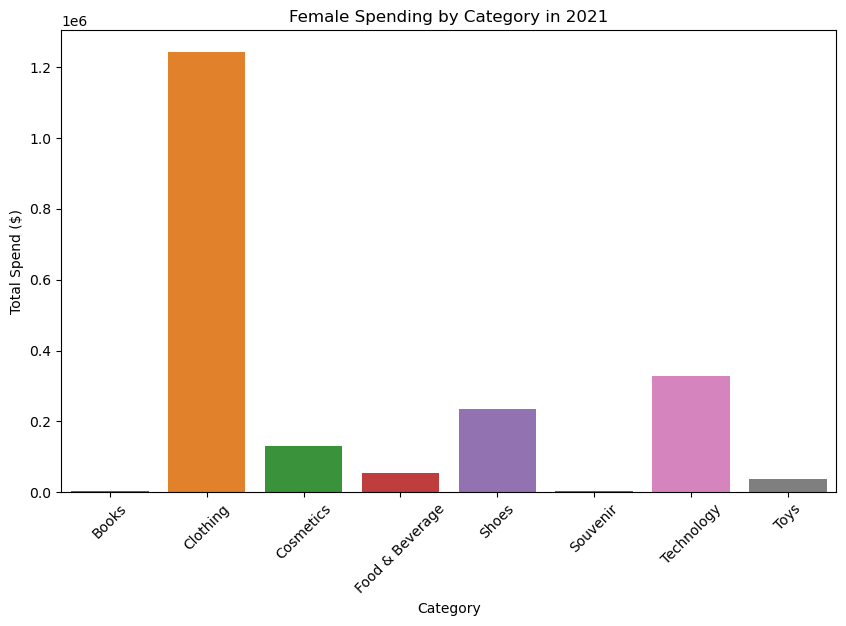

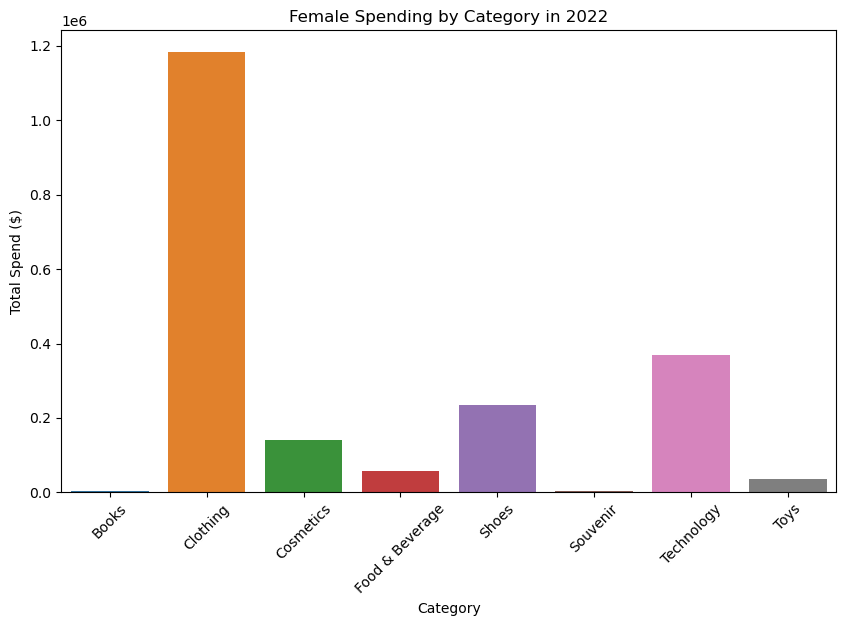

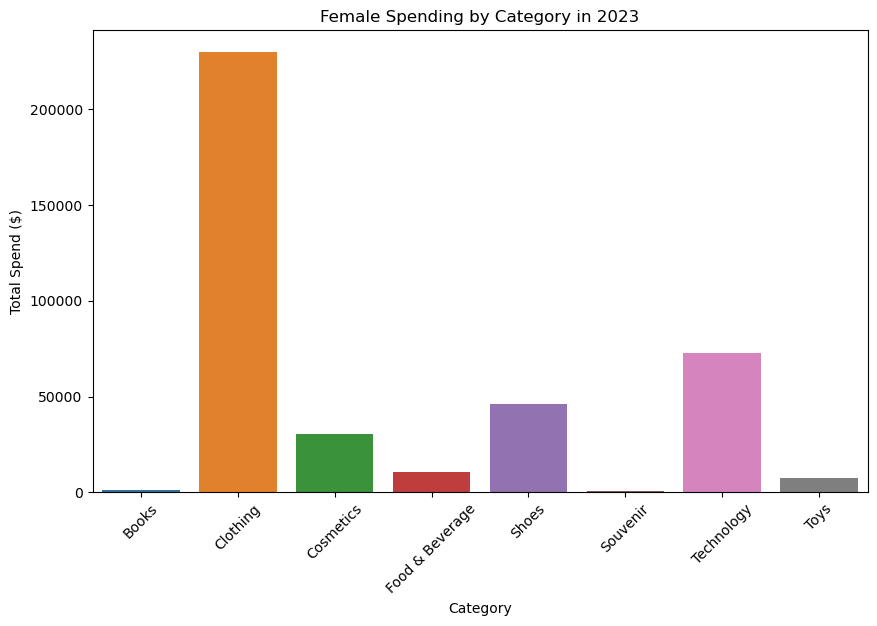

In [44]:
sns.barplot(x='year', y='USD Price', hue='gender', data=spend_by_mall_gender_year, errorbar=None)

# Filter for transactions made by females
female_data = merged_df[merged_df['gender'] == 'Female']

# Aggregate spending by category and year
spending_by_category_year = female_data.groupby(['category', 'year'])['USD Price'].sum().reset_index()

# Plot for each year
for year in spending_by_category_year['year'].unique():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='category', y='USD Price', data=spending_by_category_year[spending_by_category_year['year'] == year], errorbar=None)
    plt.title(f'Female Spending by Category in {year}')
    plt.xticks(rotation=45)
    plt.ylabel('Total Spend ($)')
    plt.xlabel('Category')
    plt.show()

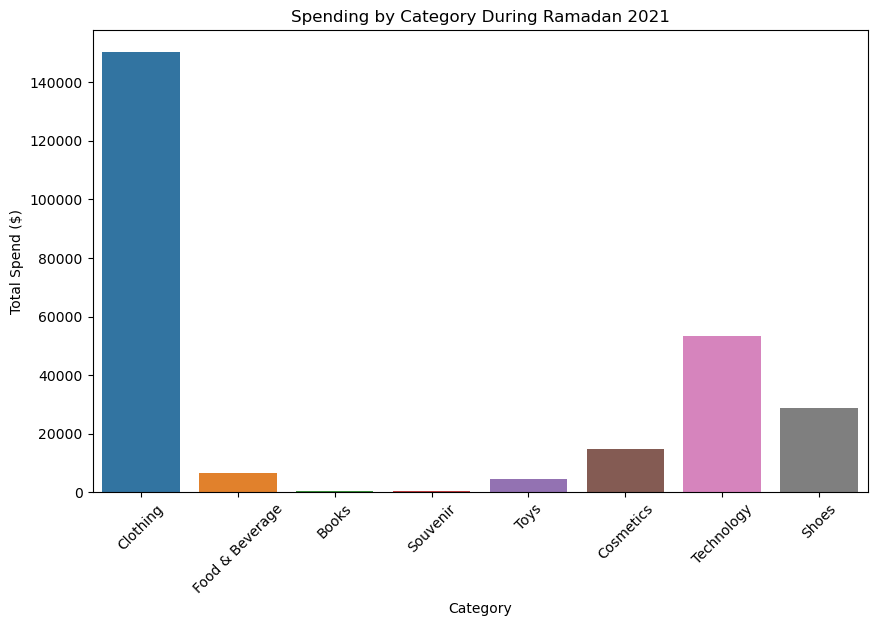

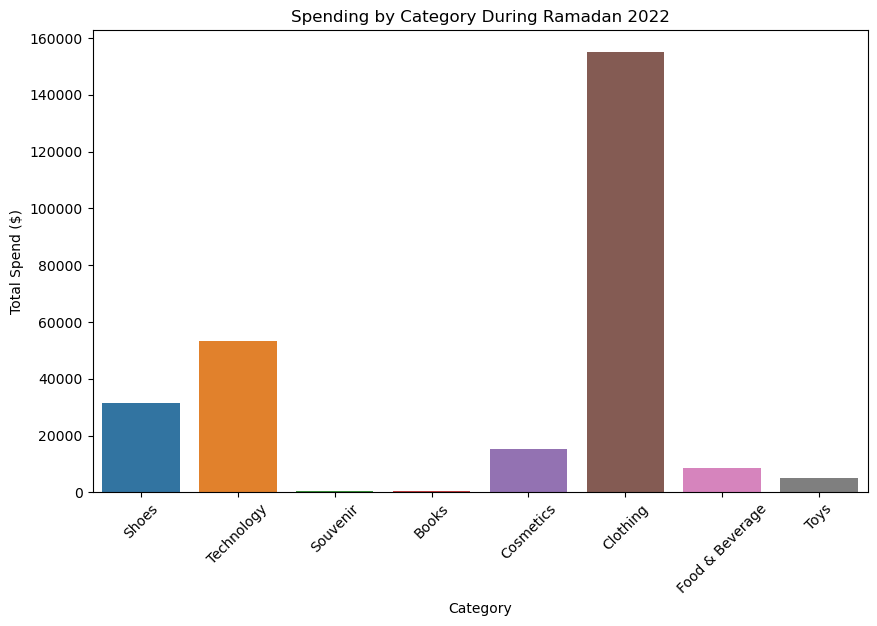

No data available for Ramadan 2023


In [45]:
# Define Ramadan dates for 2021, 2022, and 2023
ramadan_dates = {
    2021: pd.to_datetime(['2021-04-13', '2021-05-12']),
    2022: pd.to_datetime(['2022-04-02', '2022-05-01']),
    2023: pd.to_datetime(['2023-03-23', '2023-04-20']),
}

# Load the merged data
merged_df['invoice_date'] = pd.to_datetime(merged_df['invoice_date'], format='%d/%m/%Y')

# Filter the dataset for transactions during Ramadan for each year and visualize the spending
for year, dates in ramadan_dates.items():
    start_date, end_date = dates
    mask = (merged_df['invoice_date'] >= start_date) & (merged_df['invoice_date'] <= end_date)
    period_data = merged_df[mask]
    
    if not period_data.empty:  # Check if the filtered data is not empty
        plt.figure(figsize=(10, 6))
        sns.barplot(x='category', y='USD Price', data=period_data, estimator=sum, errorbar=None)
        plt.title(f'Spending by Category During Ramadan {year}')
        plt.xticks(rotation=45)
        plt.ylabel('Total Spend ($)')
        plt.xlabel('Category')
        plt.show()
    else:
        print(f'No data available for Ramadan {year}')


C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


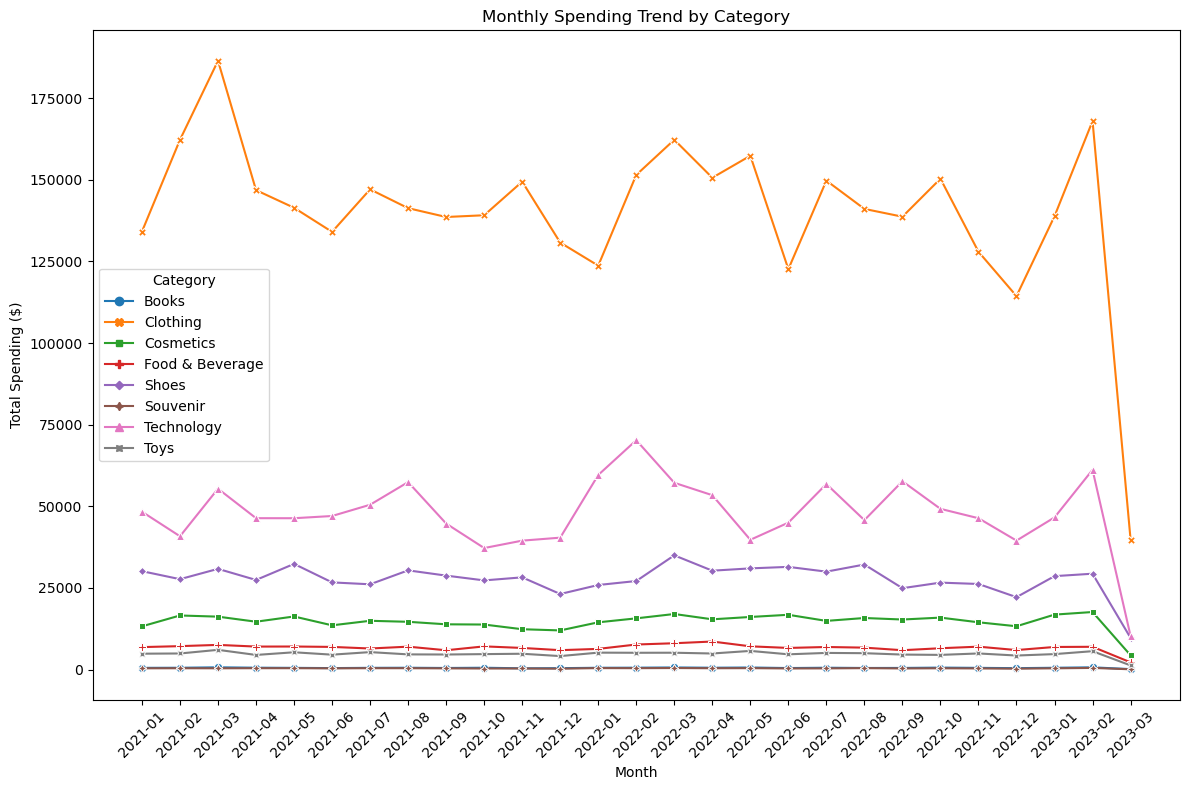

In [46]:
# Spending trend by Category over time

monthly_spending = merged_df.groupby(['Month', 'category'])['USD Price'].sum().reset_index()

# Pivot data for plotting
pivot_df = monthly_spending.pivot(index='Month', columns='category', values='USD Price')

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=pivot_df, dashes=False, markers=True)
plt.title('Monthly Spending Trend by Category')
plt.ylabel('Total Spending ($)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


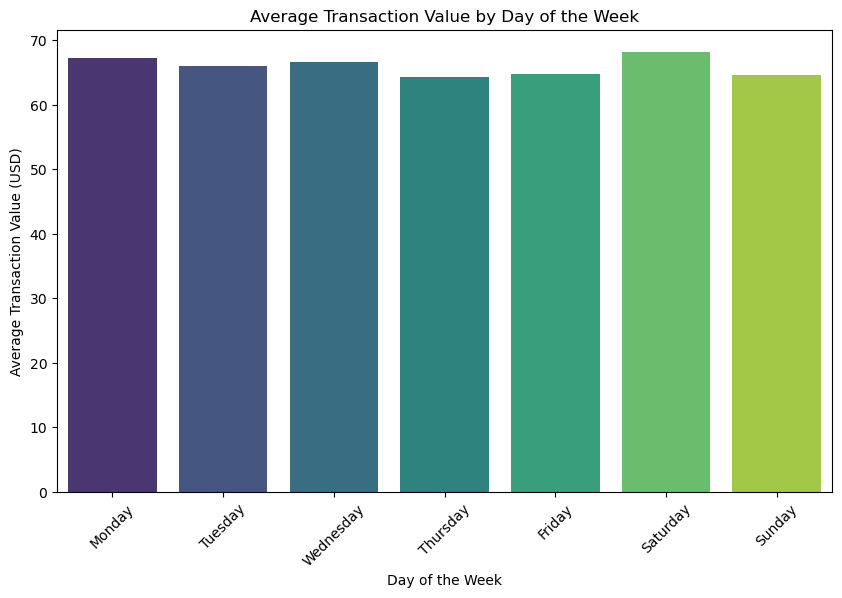

In [47]:
# comparing the average transaction value (USD Price) for each day of the week
merged_df['invoice_date'] = pd.to_datetime(merged_df['invoice_date'])
merged_df['day_of_week'] = merged_df['invoice_date'].dt.day_name()

# Calculate Average Transaction Value by Day of the Week:
merged_df['invoice_date'] = pd.to_datetime(merged_df['invoice_date'])
merged_df['day_of_week'] = merged_df['invoice_date'].dt.day_name()
avg_transaction_by_day = merged_df.groupby('day_of_week')['USD Price'].mean().reset_index()

# Order the Days of the Week:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_transaction_by_day['day_of_week'] = pd.Categorical(avg_transaction_by_day['day_of_week'], categories=days_order, ordered=True)
avg_transaction_by_day = avg_transaction_by_day.sort_values('day_of_week')

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='USD Price', data=avg_transaction_by_day, palette='viridis')
plt.title('Average Transaction Value by Day of the Week')
plt.ylabel('Average Transaction Value (USD)')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


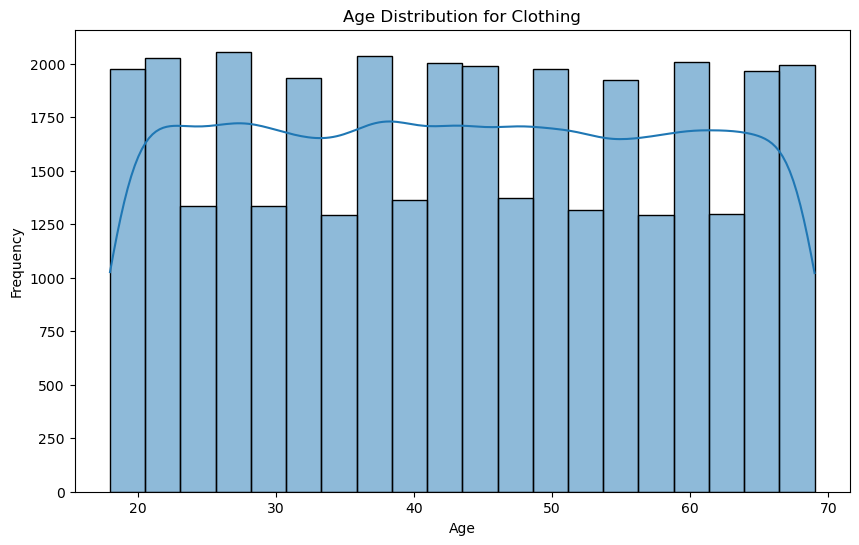

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


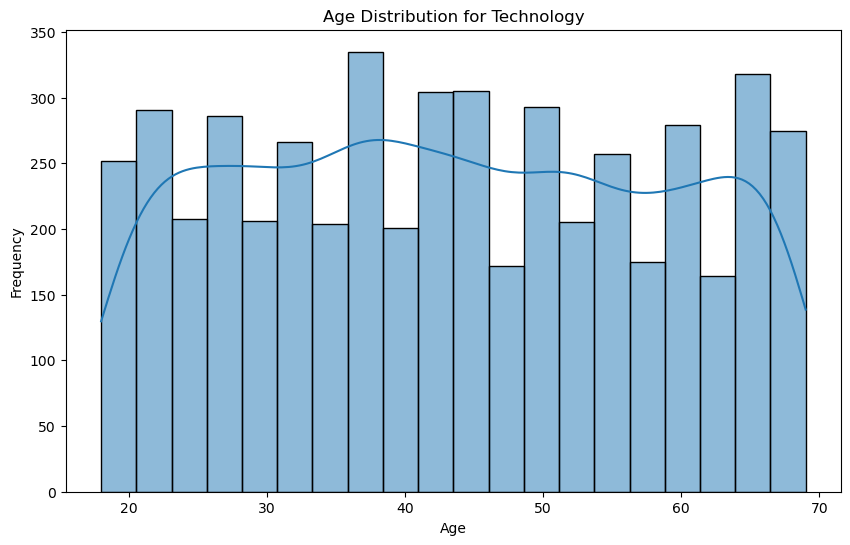

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


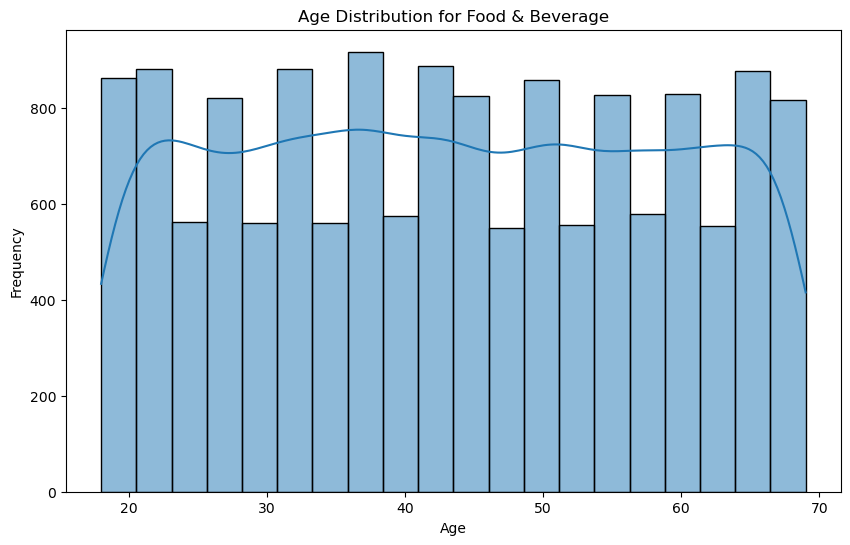

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


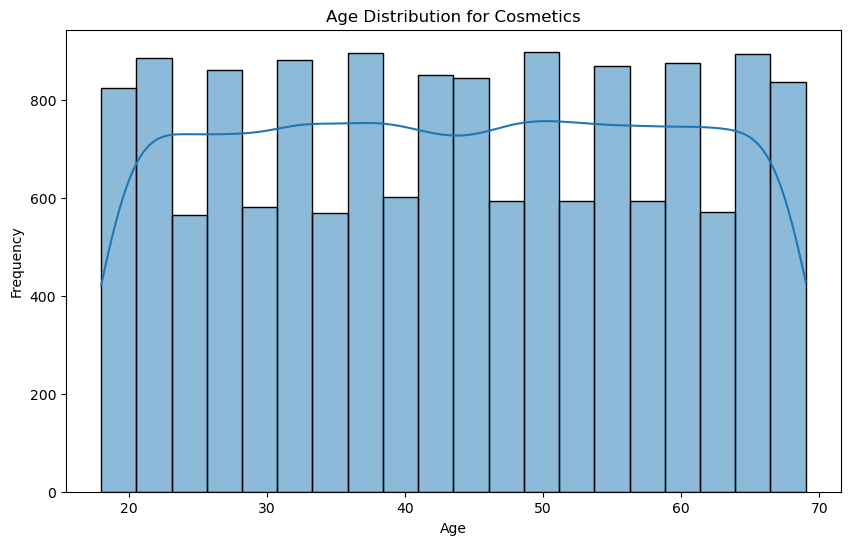

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


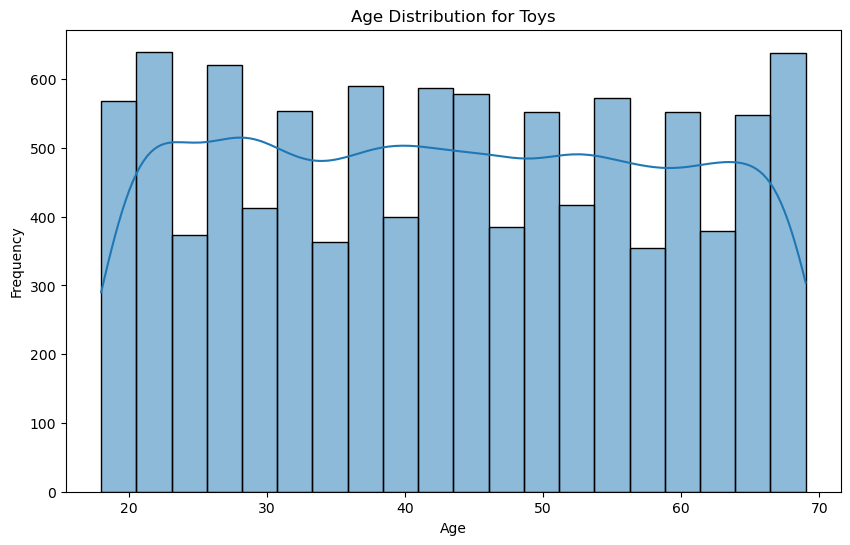

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


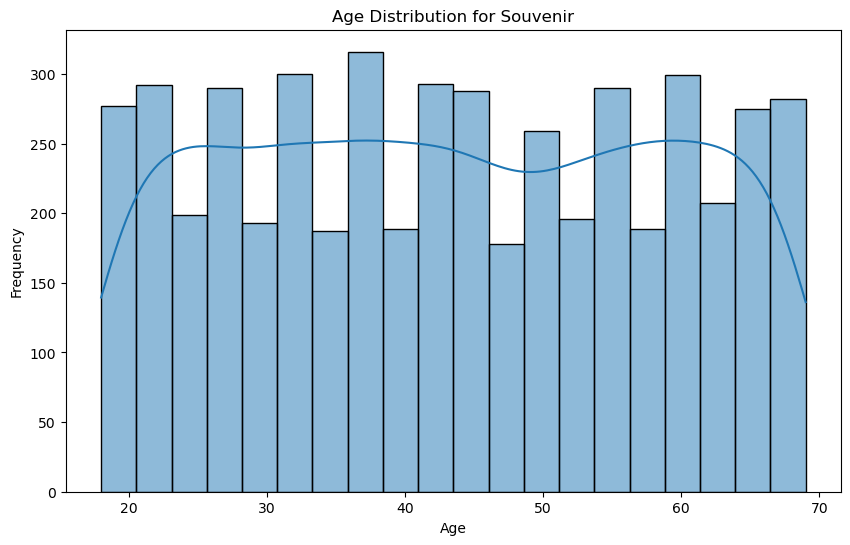

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


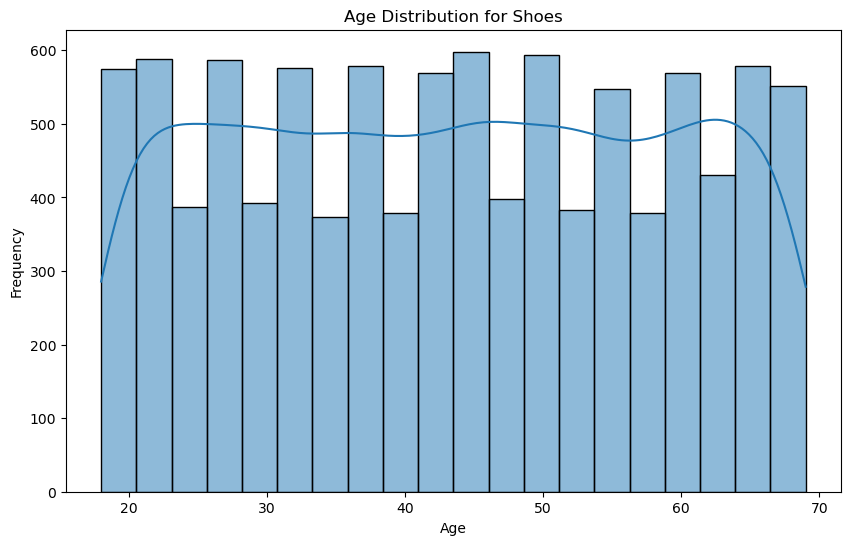

C:\Users\sarah\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


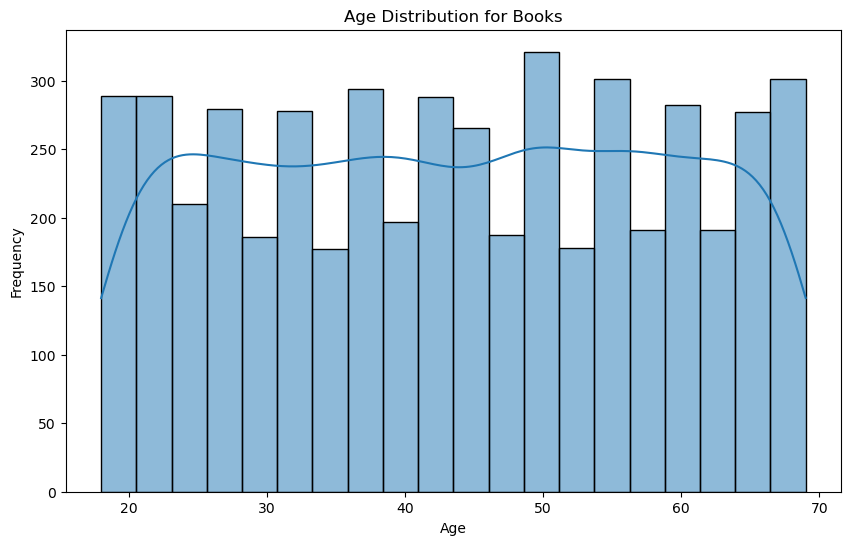

In [48]:
# Customer Age Distribution per Category

# Get unique categories
categories = merged_df['category'].unique()

# Plotting
for category in categories:
    plt.figure(figsize=(10, 6))
    category_data = merged_df[merged_df['category'] == category]
    sns.histplot(category_data['age'], bins=20, kde=True)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

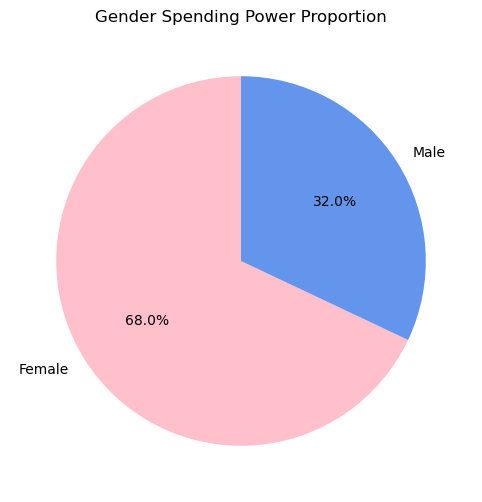

In [49]:
# gender spending power
# Calculate total spending by gender
gender_spending_power = merged_df.groupby('gender')['USD Price'].sum()

# Plotting
colors = ['pink', 'cornflowerblue']  # Female in pink, Male in blue
plt.figure(figsize=(8, 6))
gender_spending_power.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Gender Spending Power Proportion')
plt.ylabel('')  # Hide the y-label as it's not needed for pie charts
plt.show()

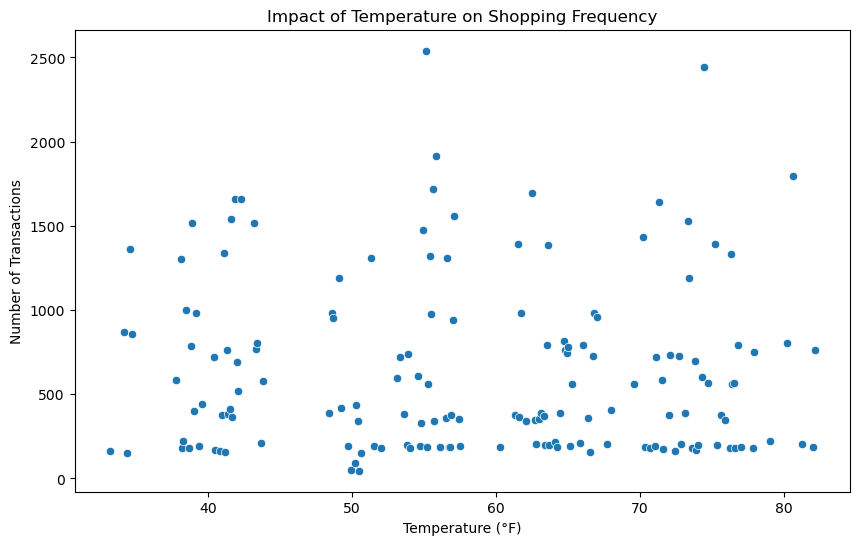

In [50]:
# Weather Impact on Shopping Frequency

# Group data by temperature, counting the number of transactions at each temperature level
transactions_by_temp = merged_df.groupby('Temp in F')['invoice_no'].nunique().reset_index()

# Creating the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temp in F', y='invoice_no', data=transactions_by_temp)
plt.title('Impact of Temperature on Shopping Frequency')
plt.xlabel('Temperature (°F)')
plt.ylabel('Number of Transactions')
plt.show()


# **Further statistical analysis**
## Author: Nataliia Shevchenko

In [51]:
def metrics_distribution_by_attribute(df, attribute_name, title_ext="", fig_height = 6.5):
    # Define a list of metrics for analysis and their corresponding colors.

    metrics = ["USD Price", "quantity"]
    colors = ["blue", "red"]
   
    # Conduct an ANOVA test because it is versatile and allows comparing any number of groups with each other.
    # Iterate through all metrics.

    for metric in metrics:
        buckets = [] 

        for bucket, group in df.groupby(attribute_name):
            buckets.append(group[metric])

        statistic, pvalue = stats.f_oneway(*buckets)

        # Display the test results and conclusion, calculated based on the p-value.

        print(f"Statistic = {statistic}, p-value = {pvalue}")
        if pvalue < 0.05:
            print(f"H0 should be rejected, indicating that there are statistically significant differences in the distribution of {metric} by {attribute_name}.\n")
        else:
            print(f"H0 should be accepted, indicating that there are no statistically significant differences in the distribution of {metric} by {attribute_name}.\n")

    # Start creating a set of charts. Determine the size of the plotting area.

    fig = plt.figure(figsize=(12, fig_height))

    # Iterate through all metrics.

    i = 1
    for metric in metrics:
       
        # Find the color in the colors list that corresponds to the metric.
        color = colors[metrics.index(metric)]

        # Construct a bar chart that shows the aggregated average value of price/cost/quantity.
        # For its construction, grouping of the original DataFrame is performed on the fly, without saving the result of grouping in a new DataFrame.

        ax1 = fig.add_subplot(2, 2, i)
        df.groupby(attribute_name).agg({metric: "mean"}).plot(kind="bar", color=color, alpha=0.75, ax=ax1)
        
        #Increment the variable value to move to the next chart.
        i = i + 1

        # Construct a boxplot that shows the distribution of price/cost/quantity values.
        ax2 = fig.add_subplot(2, 2, i)
        df.boxplot(column=metric, by=attribute_name, ax=ax2)
        plt.xticks(rotation=90)
        # Increment the variable value to move to the next chart.
        i = i + 1

    fig.suptitle(f"Distribution USD Price and Quantity by {attribute_name} {title_ext}")
    plt.tight_layout() 
    plt.show()

In [52]:
def comparison_w_equal_distribution(observed, title = ""):
    #calculated expected as an average of all observed values
    expected = [[sum(observed) / len(observed)] * len(observed)]

    #perform Chi-square test
    statistic, pvalue = stats.chisquare(f_obs=observed, f_exp=expected[0])

    #Display the test results and conclusion, calculated based on the p-value.

    print(f"Statistic = {statistic}, p-value = {pvalue}")
    if pvalue < 0.05:
        print(f"H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.\n")
    else:
        print(f"H0 should be accepted, indicating that there are no statistically significant differences in the observed distribution comparing to the equal distribution.\n")

    #draw a chart with observed (bar) and expected (line) values
    observed.plot(kind="bar")
    #draw an average line
    plt.plot(observed.index, expected[0], linestyle='-', color="red")
    plt.title(title)
    plt.show()

In [53]:
# Create a new DataFrame
payment_method_df = merged_df[["USD Price", "quantity", "payment_method"]].copy()

# Explicitly set bins 
cost_group_bins = [0, 100, 1000, 10000]
cost_group_labels = ["Lower", "Middle", "Upper"]

payment_method_df["Price Group"] = pd.cut(payment_method_df["USD Price"], bins=cost_group_bins, labels=cost_group_labels)
payment_method_df.head()

,USD Price,quantity,payment_method,Price Group
0,16.185813,2,Credit Card,Lower
1,83.327170,1,Cash,Lower
2,5.061271,18,Credit Card,Lower
3,7.335884,4,Debit Card,Lower
4,6.388325,1,Credit Card,Lower


Statistic = 7944.575154806794, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



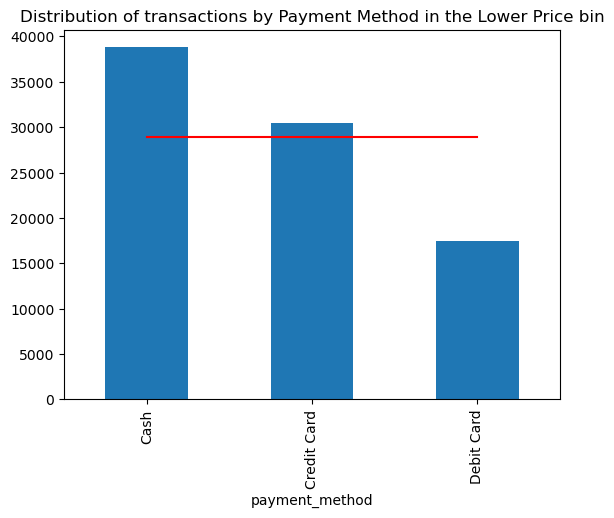

In [56]:
# Comparing the observed distribution of transaction counts by filtering by bucket number and grouping by payment method with an equal (average) distribution for Lower bin
# Within each group, count the number of entries = number of transactions
lower_bin_observed = payment_method_df[(payment_method_df["Price Group"] == "Lower")].groupby("payment_method").size()

comparison_w_equal_distribution(lower_bin_observed, "Distribution of transactions by Payment Method in the Lower Price bin")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the payment methods for number of transactions in the Lower Price bin is not random

**Cash** is the most preferrable method, while **Debit Card** is the least popular payment method

Statistic = 0.7650055172181688, p-value = 0.4653345039999929
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of USD Price by payment_method.

Statistic = 0.8578508259134794, p-value = 0.4240761080365206
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of quantity by payment_method.



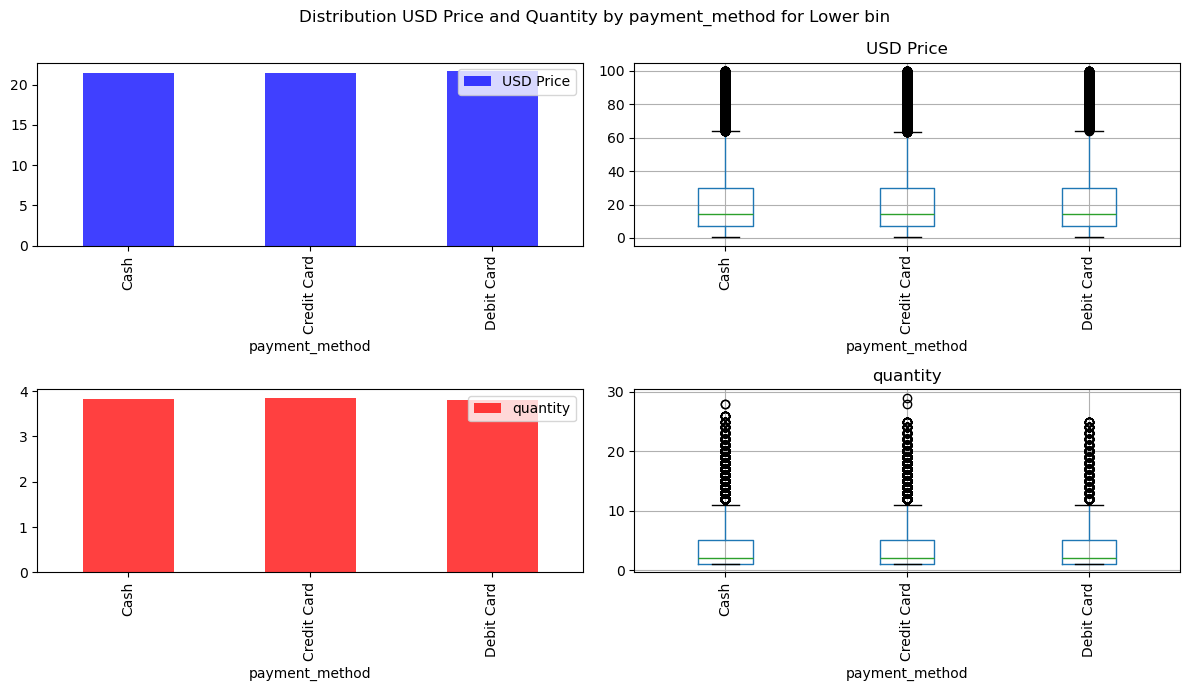

In [57]:
# ANOVA test for Price/Quantity distribution for each transaction by Payment Method for Lower bin
df = payment_method_df[(payment_method_df["Price Group"] == "Lower")]

metrics_distribution_by_attribute(df, attribute_name="payment_method", title_ext="for Lower bin", fig_height=7)

`pvalue` > 0.05 in both cases; we cannot reject H0; therefore, the difference in the payment methods for an average transaction in the **Lower Price** bin is random for average both price and average quantity of the transaction

Statistic = 49.687697160883275, p-value = 1.623505081452718e-11
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



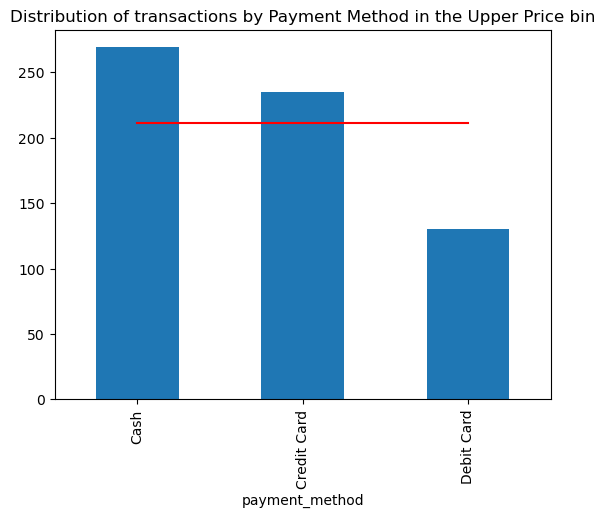

In [58]:
# Comparing the observed distribution of transaction counts by filtering by bucket number and grouping by payment method with an equal (average) distribution for Upper bin
# Within each group, count the number of entries = number of transactions
upper_bin_observed = payment_method_df[(payment_method_df["Price Group"] == "Upper")].groupby("payment_method").size()

comparison_w_equal_distribution(upper_bin_observed, "Distribution of transactions by Payment Method in the Upper Price bin")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the payment methods for number of transactions in the Lower Price bin is not random

**Cash** is the most preferrable method, **Credit Card** is slightly less preferrable, while **Debit Card** is the least popular payment method

The picture is similar to the Lower Price bin, but **Credit Card** payment method is more popular

payment_method
Cash           38784
Credit Card    30423
Debit Card     17514
dtype: int64


Statistic = 0.7650055172181688, p-value = 0.4653345039999929
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of USD Price by payment_method.

Statistic = 0.8578508259134794, p-value = 0.4240761080365206
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of quantity by payment_method.



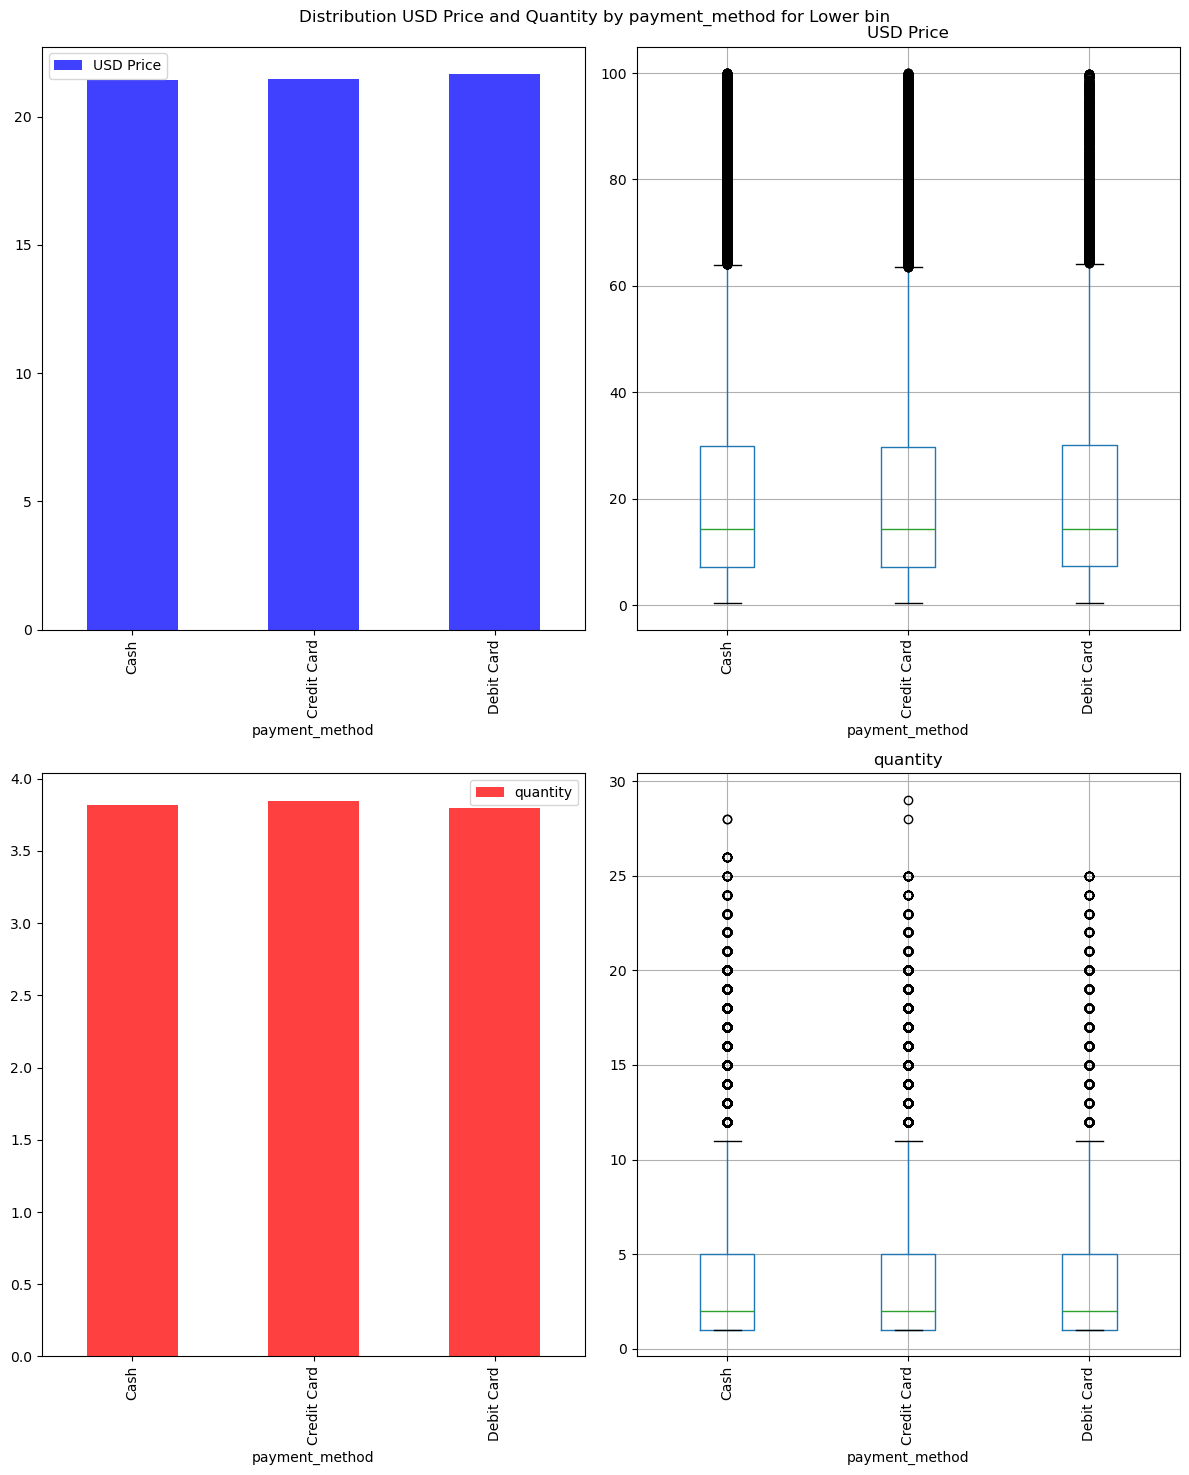

In [64]:
# Perform an ANOVA test for the distribution of Price/Cost/Quantity for each purchase by Payment Method in the Lower bin.
df = payment_method_df[(payment_method_df["Price Group"] == "Lower")]

# Display the number of transactions in each group.
print(payment_method_df[(payment_method_df["Price Group"] == "Lower")].groupby("payment_method").size())
print("\n")

metrics_distribution_by_attribute(df, attribute_name="payment_method", title_ext="for Lower bin", fig_height=15)

payment_method
Cash           269
Credit Card    235
Debit Card     130
dtype: int64


Statistic = 0.19515920303678724, p-value = 0.8227533100698767
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of USD Price by payment_method.

Statistic = 3.368892076749653, p-value = 0.03504814209047556
H0 should be rejected, indicating that there are statistically significant differences in the distribution of quantity by payment_method.



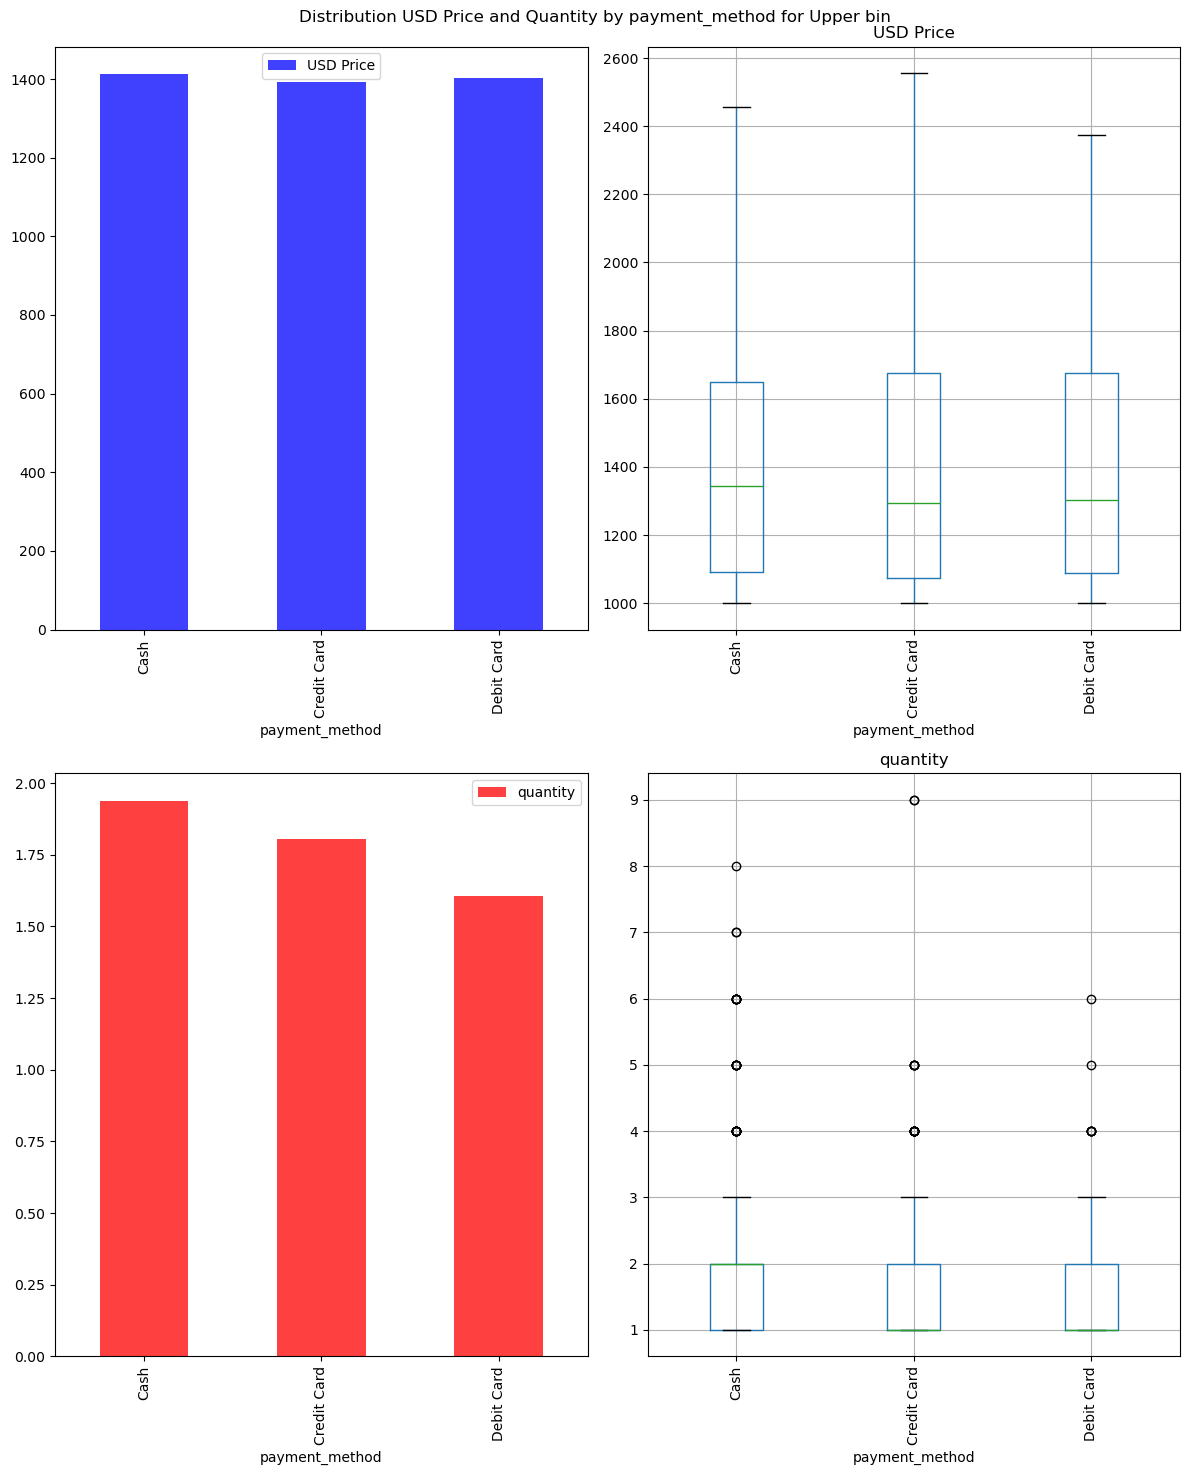

In [65]:
# Perform an ANOVA test for the distribution of Price/Cost/Quantity for each purchase by Payment Method in the Lower bin.
df = payment_method_df[(payment_method_df["Price Group"] == "Upper")]

# Display the number of transactions in each group.
print(payment_method_df[(payment_method_df["Price Group"] == "Upper")].groupby("payment_method").size())
print("\n")

metrics_distribution_by_attribute(df, attribute_name="payment_method", title_ext="for Upper bin", fig_height=15)

In [94]:
merged_df['age bin']=pd.cut(merged_df['age'], bins=5, precision=0)
total_spend_by_age = merged_df.groupby(['age bin'])['USD Price'].sum()
total_spend_by_age = total_spend_by_age.reset_index()
total_spend_by_age['USD Price'] = total_spend_by_age['USD Price']/1000
total_spend_by_age = total_spend_by_age.rename(columns={'USD Price':'Total Spend $000s', 'age bin':'Age Range'})
total_spend_by_age

C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\508378525.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_spend_by_age = merged_df.groupby(['age bin'])['USD Price'].sum()


,Age Range,Total Spend $000s
0,"(18.0, 28.0]",1398.493102
1,"(28.0, 38.0]",1311.472391
2,"(38.0, 49.0]",1272.415548
3,"(49.0, 59.0]",1196.579153
4,"(59.0, 69.0]",1382.781882


C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\743939612.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bucket, group in df.groupby(attribute_name):
C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\743939612.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(attribute_name).agg({metric: "mean"}).plot(kind="bar", color=color, alpha=0.75, ax=ax1)


Statistic = 0.6888161003902152, p-value = 0.5995845138994043
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of USD Price by age bin.

Statistic = 0.843203501693892, p-value = 0.49748925702360414
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of quantity by age bin.



C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\743939612.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(attribute_name).agg({metric: "mean"}).plot(kind="bar", color=color, alpha=0.75, ax=ax1)


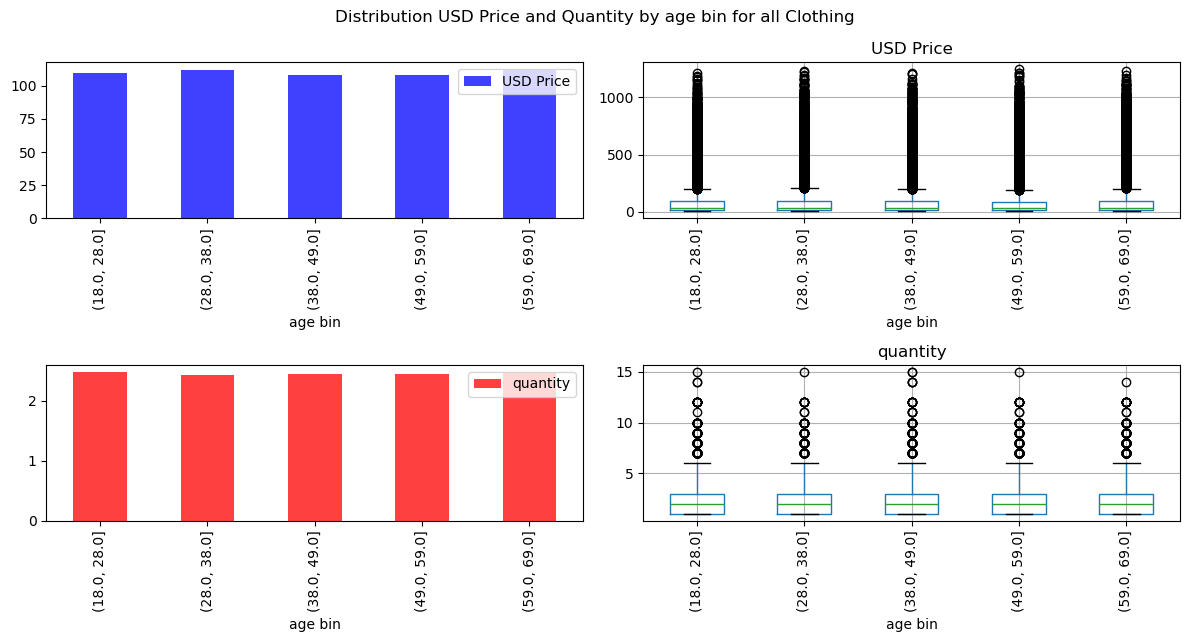

In [95]:
df = merged_df[(merged_df["category"] == "Clothing")]

metrics_distribution_by_attribute(df, attribute_name="age bin", title_ext="for all Clothing")

C:\Users\sarah\AppData\Local\Temp\ipykernel_31084\743939612.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bucket, group in df.groupby(attribute_name):
C:\Users\sarah\AppData\Local\Temp\ipykernel_31084\743939612.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(attribute_name).agg({metric: "mean"}).plot(kind="bar", color=color, alpha=0.75, ax=ax1)
C:\Users\sarah\AppData\Local\Temp\ipykernel_31084\743939612.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

Statistic = 1.546745583431093, p-value = 0.18562184500305656
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of USD Price by age bin.

Statistic = 0.37663838276381034, p-value = 0.825479298199068
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of quantity by age bin.



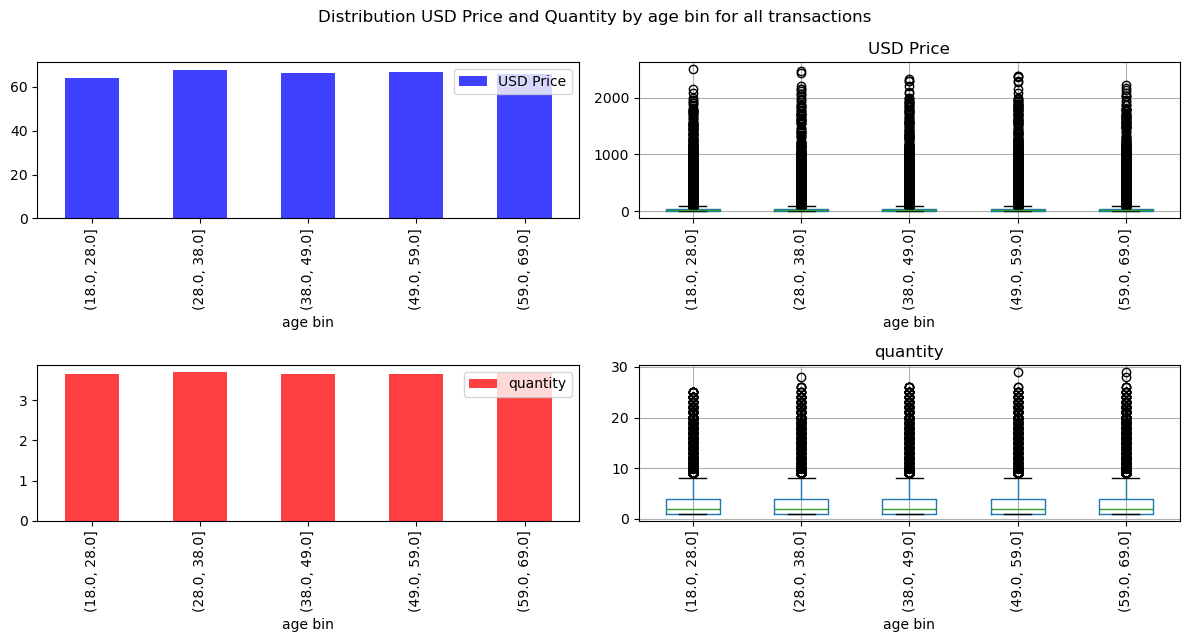

In [159]:
df = merged_df #[(merged_df["category"] == "Clothing")]

metrics_distribution_by_attribute(df, attribute_name="age bin", title_ext="for all transactions")

C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\743939612.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bucket, group in df.groupby(attribute_name):
C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\743939612.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(attribute_name).agg({metric: "mean"}).plot(kind="bar", color=color, alpha=0.75, ax=ax1)
C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\743939612.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

Statistic = 0.6888161003902152, p-value = 0.5995845138994043
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of USD Price by age bin.

Statistic = 0.843203501693892, p-value = 0.49748925702360414
H0 should be accepted, indicating that there are no statistically significant differences in the distribution of quantity by age bin.



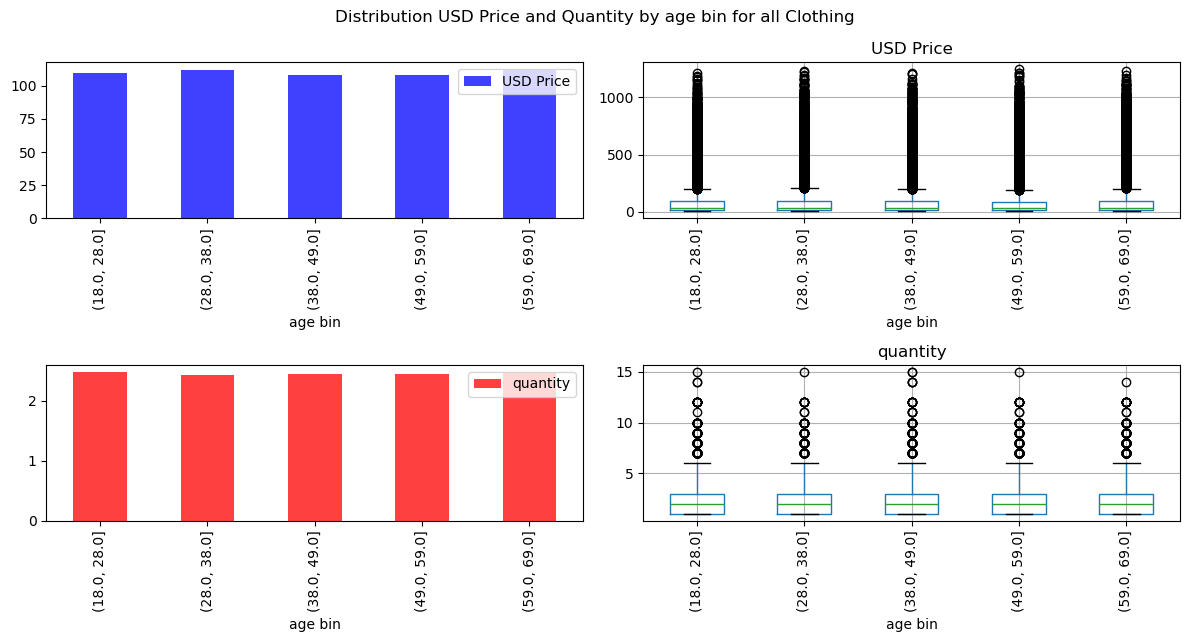

In [68]:
# Test the hypothesis that the price/cost/quantity of products purchased in a single transaction within a certain category depends on the age of the buyers

# group ages into bins
merged_df['age bin']=pd.cut(merged_df['age'], bins=5, precision=0)

# Check Clothing category
df = merged_df[(merged_df["category"] == "Clothing")]

metrics_distribution_by_attribute(df, attribute_name="age bin", title_ext="for all Clothing")

Statistic = 10.801816518849265, p-value = 0.0010210067034440596
H0 should be rejected, indicating that there are statistically significant differences in the distribution of USD Price by gender.

Statistic = 11.172572102904926, p-value = 0.0008362570216861698
H0 should be rejected, indicating that there are statistically significant differences in the distribution of quantity by gender.



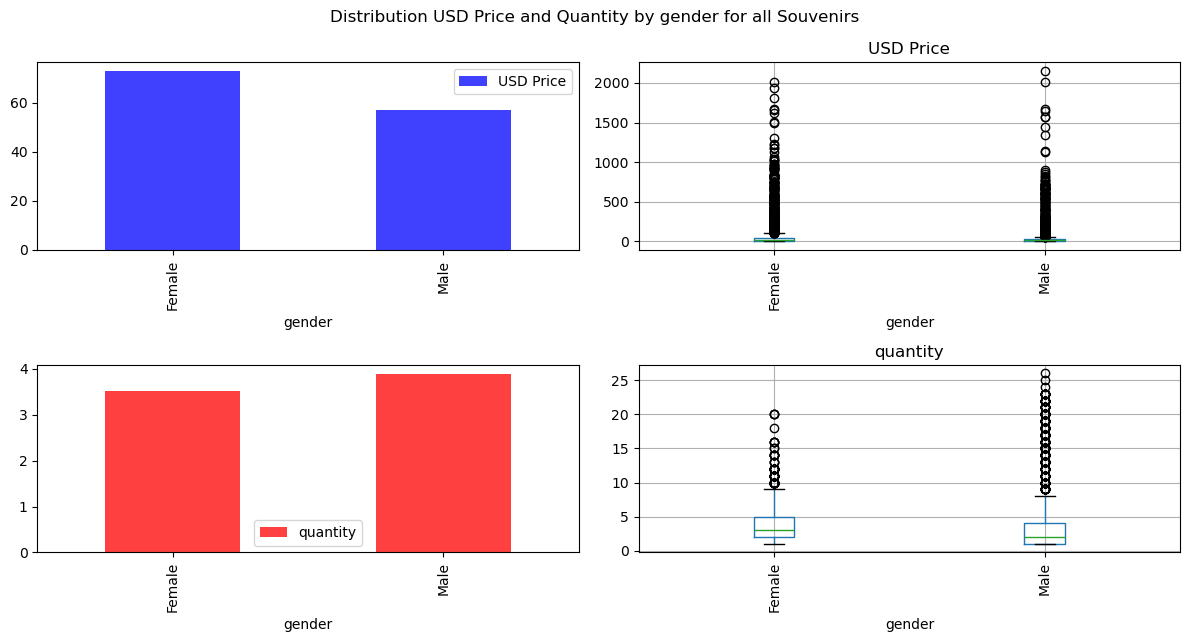

In [69]:
# Check Souvenir category
df = merged_df[(customer_shopping_data_df["category"] == "Souvenir")]

metrics_distribution_by_attribute(df, attribute_name="gender", title_ext="for all Souvenirs")

Statistic = 88.247967692212, p-value = 6.584946486812293e-21
H0 should be rejected, indicating that there are statistically significant differences in the distribution of USD Price by gender.

Statistic = 61.75206051564298, p-value = 4.157093047152856e-15
H0 should be rejected, indicating that there are statistically significant differences in the distribution of quantity by gender.



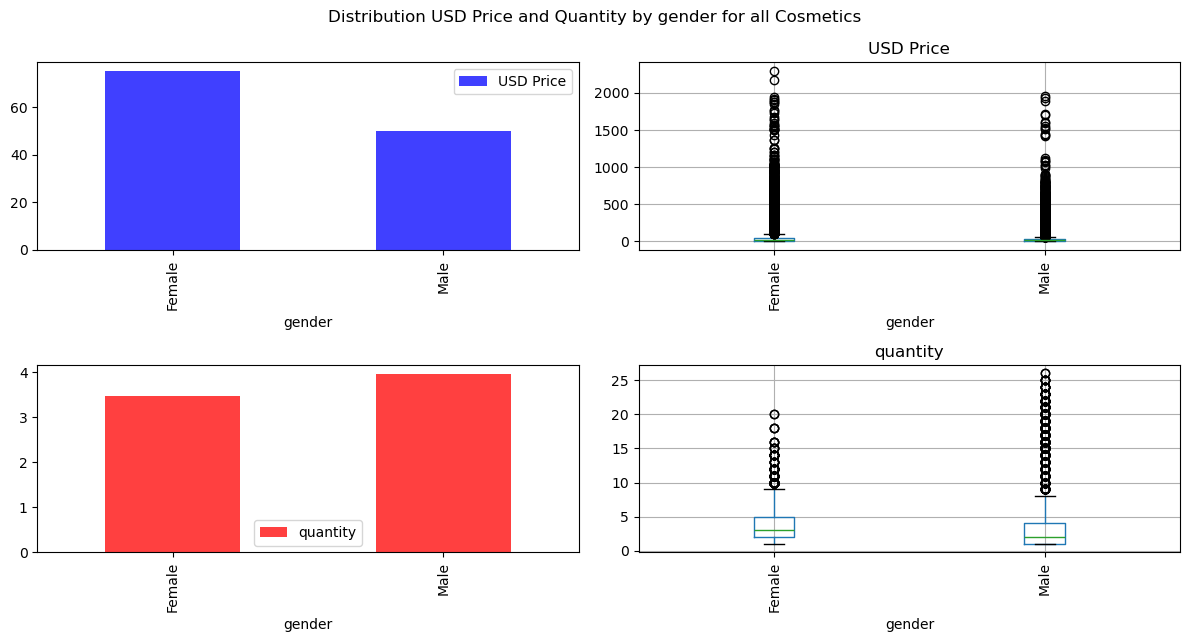

In [70]:
# Check Cosmetics category
df = merged_df[(customer_shopping_data_df["category"] == "Cosmetics")]

metrics_distribution_by_attribute(df, attribute_name="gender", title_ext="for all Cosmetics")

# **Additional Analysis**
## Author: Sarah Fawzy and Kevin Lee

In [60]:
merged_df['spending_bin']=pd.cut(merged_df['USD Price'], bins=5)
merged_df_pivot=merged_df.pivot_table(index='spending_bin', columns=['payment_method'], aggfunc='size')
merged_df_pivot

payment_method,Cash,Credit Card,Debit Card
spending_bin,,,
"(-2.151, 511.551]",43135,33841,19461
"(511.551, 1022.697]",1058,878,496
"(1022.697, 1533.844]",159,135,76
"(1533.844, 2044.99]",85,67,40
"(2044.99, 2556.136]",10,10,6


array([<Axes: title={'center': 'Cash'}, ylabel=' '>,
       <Axes: title={'center': 'Credit Card'}, ylabel=' '>,
       <Axes: title={'center': 'Debit Card'}, ylabel=' '>], dtype=object)

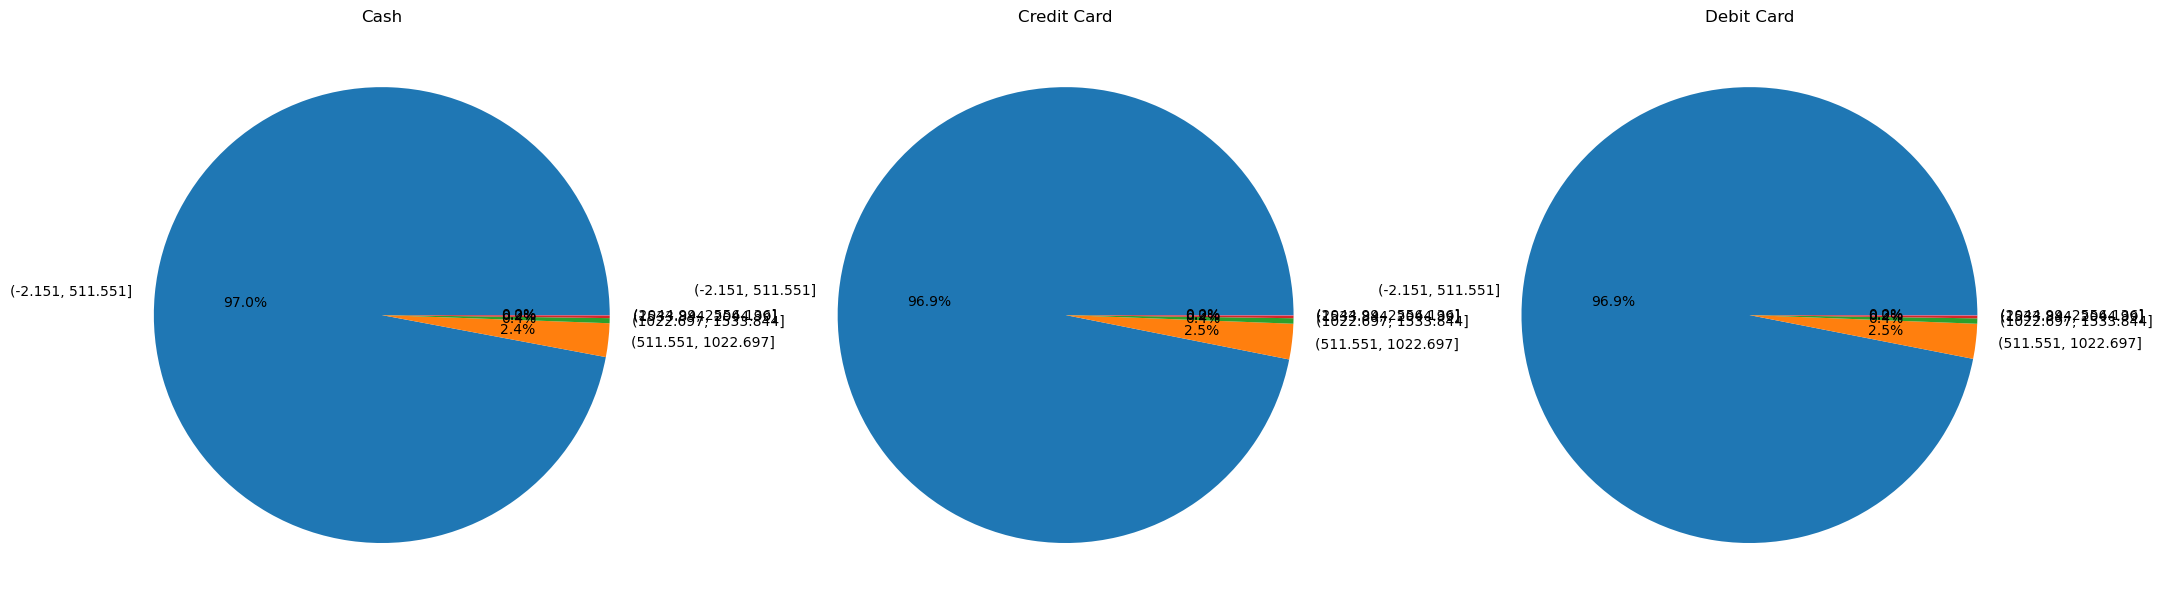

In [63]:
merged_df_pivot_chart = merged_df_pivot.plot.pie(subplots=True, figsize=(25, 10), autopct='%1.1f%%', legend=False, title=['Cash', 'Credit Card', 'Debit Card'], ylabel=' ')
merged_df_pivot_chart

In [71]:
merged_df['age bin']=pd.cut(merged_df['age'], bins=5, precision=0)
total_spend_by_age = merged_df.groupby(['age bin'])['USD Price'].sum()
total_spend_by_age = total_spend_by_age.reset_index()
total_spend_by_age['USD Price'] = total_spend_by_age['USD Price']/1000
total_spend_by_age = total_spend_by_age.rename(columns={'USD Price':'Total Spend $000s', 'age bin':'Age Range'})
total_spend_by_age

C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\508378525.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_spend_by_age = merged_df.groupby(['age bin'])['USD Price'].sum()


,Age Range,Total Spend $000s
0,"(18.0, 28.0]",1398.493102
1,"(28.0, 38.0]",1311.472391
2,"(38.0, 49.0]",1272.415548
3,"(49.0, 59.0]",1196.579153
4,"(59.0, 69.0]",1382.781882


In [72]:
avg_spend_by_age = merged_df.groupby(['age bin'])['USD Price'].mean()
avg_spend_by_age = avg_spend_by_age.reset_index()
avg_spend_by_age = avg_spend_by_age.rename(columns={'USD Price':'Avg Spend Per Transaction', 'age bin':'Age Range'})
avg_spend_by_age

C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\3910934042.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_spend_by_age = merged_df.groupby(['age bin'])['USD Price'].mean()


,Age Range,Avg Spend Per Transaction
0,"(18.0, 28.0]",66.097604
1,"(28.0, 38.0]",68.217029
2,"(38.0, 49.0]",66.213017
3,"(49.0, 59.0]",63.177358
4,"(59.0, 69.0]",66.108040


In [73]:
trns_by_age = merged_df.groupby(['age bin'])['USD Price'].size()
trns_by_age = trns_by_age.reset_index()
trns_by_age = trns_by_age.rename(columns={'USD Price':'Number of Transaction', 'age bin':'Age Range'})
trns_by_age

C:\Users\sarah\AppData\Local\Temp\ipykernel_4796\872945549.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trns_by_age = merged_df.groupby(['age bin'])['USD Price'].size()


,Age Range,Number of Transaction
0,"(18.0, 28.0]",21158
1,"(28.0, 38.0]",19225
2,"(38.0, 49.0]",19217
3,"(49.0, 59.0]",18940
4,"(59.0, 69.0]",20917


In [75]:
analysis_by_age = total_spend_by_age.merge(avg_spend_by_age, on = 'Age Range')
analysis_by_age

,Age Range,Total Spend $000s,Avg Spend Per Transaction
0,"(18.0, 28.0]",1398.493102,66.097604
1,"(28.0, 38.0]",1311.472391,68.217029
2,"(38.0, 49.0]",1272.415548,66.213017
3,"(49.0, 59.0]",1196.579153,63.177358
4,"(59.0, 69.0]",1382.781882,66.108040


In [76]:
analysis_by_age = analysis_by_age.merge(trns_by_age, on = 'Age Range')
analysis_by_age

,Age Range,Total Spend $000s,Avg Spend Per Transaction,Number of Transaction
0,"(18.0, 28.0]",1398.493102,66.097604,21158
1,"(28.0, 38.0]",1311.472391,68.217029,19225
2,"(38.0, 49.0]",1272.415548,66.213017,19217
3,"(49.0, 59.0]",1196.579153,63.177358,18940
4,"(59.0, 69.0]",1382.781882,66.108040,20917


In [77]:
analysis_by_age['Total Spend $000s'] = analysis_by_age['Total Spend $000s'].map('${:,.2f}'.format)
analysis_by_age['Avg Spend Per Transaction'] = analysis_by_age['Avg Spend Per Transaction'].map('${:,.2f}'.format)
analysis_by_age

,Age Range,Total Spend $000s,Avg Spend Per Transaction,Number of Transaction
0,"(18.0, 28.0]","$1,398.49",$66.10,21158
1,"(28.0, 38.0]","$1,311.47",$68.22,19225
2,"(38.0, 49.0]","$1,272.42",$66.21,19217
3,"(49.0, 59.0]","$1,196.58",$63.18,18940
4,"(59.0, 69.0]","$1,382.78",$66.11,20917


# **Additional Analysis**
## Author: Nataliia Shevchenko

# Shopping malls traffic
## Checking the hypothesis are there shopping malls that are preferable by females more than males and vice versa?

In [78]:
# Test the hypothesis that women or men prefer some malls over others.
# H0 - women (and men) visit all malls with equal frequency, not favoring any specific ones.
# Calculate the proportion of women and men in the entire dataset. This ratio is 60:40.

female_ratio = merged_df[(merged_df["gender"] == "Female")]["gender"].count() / len(merged_df)
male_ratio = merged_df[(merged_df["gender"] == "Male")]["gender"].count() / len(merged_df)

print(female_ratio)
print(male_ratio)

0.5980675065606242
0.4019324934393758


In [79]:
# Insert data for the chi-square test, which determines whether the deviations of actual values from expected ones are statistically significant.
# DataFrame needs to be created where each row corresponds to a mall and there are two columns - expected and actual visits.
# Obtain the distribution of the number of customers across all malls.
customers_by_malls = merged_df.groupby("shopping_mall").size()
# Obtain the distribution of the actual number of female customers across all malls.
female_customers_by_mall_observed = merged_df[(merged_df["gender"] == "Female")].groupby("shopping_mall").size()
# Obtain the distribution of the actual number of male customers across all malls.
male_customers_by_mall_observed = merged_df[(merged_df["gender"] == "Male")].groupby("shopping_mall").size()
# Calculate the expected number of customers of both genders, using the formula total number of customers x the proportion of women (men) in the overall distribution.
female_customers_by_mall_expected = customers_by_malls * female_ratio
male_customers_by_mall_expected = customers_by_malls * male_ratio

print(customers_by_malls)
print(female_customers_by_mall_observed)
print(male_customers_by_mall_observed)
print(female_customers_by_mall_expected)
print(male_customers_by_mall_expected)

shopping_mall
Cevahir AVM           4991
Emaar Square Mall     4811
Forum Istanbul        4947
Istinye Park          9781
Kanyon               19823
Mall of Istanbul     19943
Metrocity            15011
Metropol AVM         10161
Viaport Outlet        4914
Zorlu Center          5075
dtype: int64
shopping_mall
Cevahir AVM           2940
Emaar Square Mall     2842
Forum Istanbul        3016
Istinye Park          5874
Kanyon               11906
Mall of Istanbul     11902
Metrocity             8941
Metropol AVM          6144
Viaport Outlet        2949
Zorlu Center          2968
dtype: int64
shopping_mall
Cevahir AVM          2051
Emaar Square Mall    1969
Forum Istanbul       1931
Istinye Park         3907
Kanyon               7917
Mall of Istanbul     8041
Metrocity            6070
Metropol AVM         4017
Viaport Outlet       1965
Zorlu Center         2107
dtype: int64
shopping_mall
Cevahir AVM           2984.954925
Emaar Square Mall     2877.302774
Forum Istanbul        2958.639955
Ist

In [80]:
female_customers_by_mall = pd.DataFrame({
    "observed": female_customers_by_mall_observed,
    "expected": female_customers_by_mall_expected
})

female_customers_by_mall

,observed,expected
shopping_mall,,
Cevahir AVM,2940,2984.954925
Emaar Square Mall,2842,2877.302774
Forum Istanbul,3016,2958.639955
Istinye Park,5874,5849.698282
Kanyon,11906,11855.492183
Mall of Istanbul,11902,11927.260283
Metrocity,8941,8977.591341
Metropol AVM,6144,6076.963934
Viaport Outlet,2949,2938.903727


In [81]:
male_customers_by_mall = pd.DataFrame({
    "observed": male_customers_by_mall_observed,
    "expected": male_customers_by_mall_expected
})

male_customers_by_mall

,observed,expected
shopping_mall,,
Cevahir AVM,2051,2006.045075
Emaar Square Mall,1969,1933.697226
Forum Istanbul,1931,1988.360045
Istinye Park,3907,3931.301718
Kanyon,7917,7967.507817
Mall of Istanbul,8041,8015.739717
Metrocity,6070,6033.408659
Metropol AVM,4017,4084.036066
Viaport Outlet,1965,1975.096273


16.918977604620448
Power_divergenceResult(statistic=5.002688625817329, pvalue=0.8340738229321143)


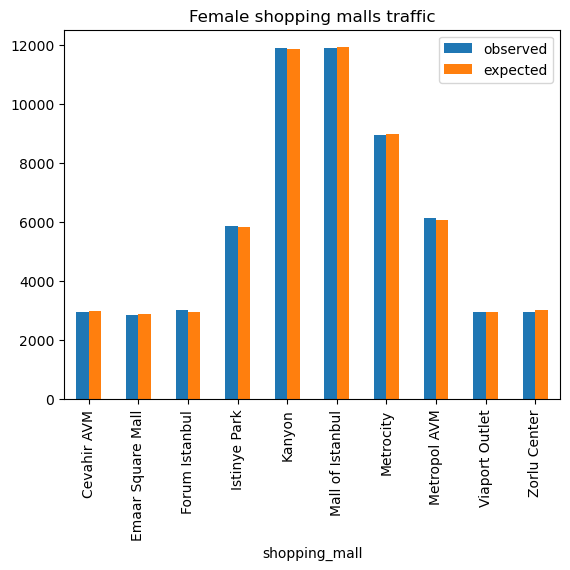

In [82]:
# Conduct a chi-square test for female visitation.
# Calculate the critical value (exceeding which we can consider the difference in visitation to be statistically significant).

degree_of_freedom = len(female_customers_by_mall) - 1
p_value = 0.05
confidence_level = 1- p_value

critical_value = stats.chi2.ppf(confidence_level, degree_of_freedom)
print(critical_value)

print(stats.chisquare(f_obs=female_customers_by_mall["observed"], f_exp=female_customers_by_mall["expected"]))

female_customers_by_mall.plot(kind="bar")
plt.title("Female shopping malls traffic")
plt.show()

16.918977604620448
Power_divergenceResult(statistic=7.4439005588709115, pvalue=0.5910054758206086)


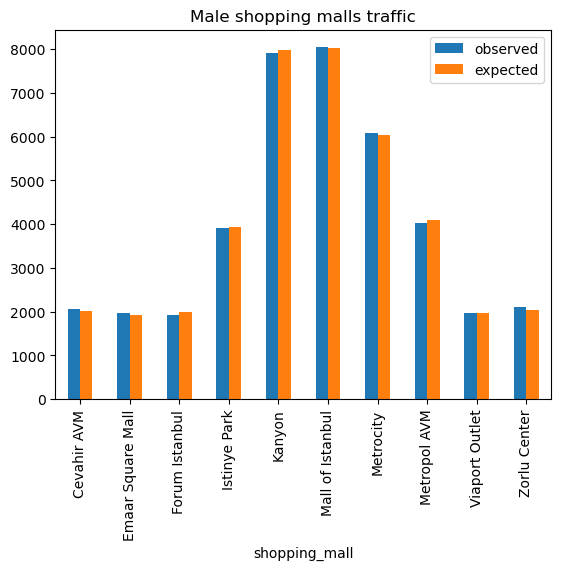

In [180]:
#Conduct a chi-square test for male visitation.
#Calculate the critical value (exceeding which we can consider the difference in visitation to be statistically significant).

degree_of_freedom = len(male_customers_by_mall) - 1
p_value = 0.05
confidence_level = 1- p_value

critical_value = stats.chi2.ppf(confidence_level, degree_of_freedom)
print(critical_value)

print(stats.chisquare(f_obs=male_customers_by_mall["observed"], f_exp=male_customers_by_mall["expected"]))

male_customers_by_mall.plot(kind="bar")
plt.title("Male shopping malls traffic")
plt.show()

# Seasonal Variance Analysis
Analysis of dependency between sales activity and a month of a year

In [83]:
# Analysis of dependency between sales activity and a month of a year
# Adding Year and Month Number attributes to the DataFrame
merged_df[["Year", "Month Number"]] = merged_df["Month"].str.split('-', expand=True)
merged_df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,...,TRY-USD fx rate,USD Price,bad_weather,weekend,year,day_of_week,spending_bin,age bin,Year,Month Number
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,2022-08-05,Kanyon,...,17.912600,16.185813,False,False,2022,Friday,"(-2.151, 511.551]","(18.0, 28.0]",2022,08
1,I289643,C584700,Female,43,Technology,1,1508.68,Cash,2022-08-22,Kanyon,...,18.105499,83.327170,False,False,2022,Monday,"(-2.151, 511.551]","(38.0, 49.0]",2022,08
2,I184307,C175946,Male,22,Food & Beverage,18,91.98,Credit Card,2022-08-25,Kanyon,...,18.173301,5.061271,False,False,2022,Thursday,"(-2.151, 511.551]","(18.0, 28.0]",2022,08
3,I818298,C204632,Male,21,Clothing,4,132.75,Debit Card,2022-08-21,Kanyon,...,18.095979,7.335884,False,True,2022,Sunday,"(-2.151, 511.551]","(18.0, 28.0]",2022,08
4,I215578,C866033,Male,39,Cosmetics,1,114.65,Credit Card,2022-08-04,Kanyon,...,17.946800,6.388325,False,False,2022,Thursday,"(-2.151, 511.551]","(38.0, 49.0]",2022,08


In [84]:
# Analyze the seasonal dependencies of customers,
# including the impact of weather conditions on purchasing activity.
# This analysis will enable the planning of marketing campaigns tailored to specific months or weather conditions.
# Data is isolated to complete years only before commencing the analysis.

full_years_df = merged_df[(merged_df["Year"].isin(["2021", "2022"]))]
full_years_df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,...,TRY-USD fx rate,USD Price,bad_weather,weekend,year,day_of_week,spending_bin,age bin,Year,Month Number
0,I138884,C241288,Female,28,Clothing,2,289.93,Credit Card,2022-08-05,Kanyon,...,17.912600,16.185813,False,False,2022,Friday,"(-2.151, 511.551]","(18.0, 28.0]",2022,08
1,I289643,C584700,Female,43,Technology,1,1508.68,Cash,2022-08-22,Kanyon,...,18.105499,83.327170,False,False,2022,Monday,"(-2.151, 511.551]","(38.0, 49.0]",2022,08
2,I184307,C175946,Male,22,Food & Beverage,18,91.98,Credit Card,2022-08-25,Kanyon,...,18.173301,5.061271,False,False,2022,Thursday,"(-2.151, 511.551]","(18.0, 28.0]",2022,08
3,I818298,C204632,Male,21,Clothing,4,132.75,Debit Card,2022-08-21,Kanyon,...,18.095979,7.335884,False,True,2022,Sunday,"(-2.151, 511.551]","(18.0, 28.0]",2022,08
4,I215578,C866033,Male,39,Cosmetics,1,114.65,Credit Card,2022-08-04,Kanyon,...,17.946800,6.388325,False,False,2022,Thursday,"(-2.151, 511.551]","(38.0, 49.0]",2022,08


Statistic = 30000.52967098127, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



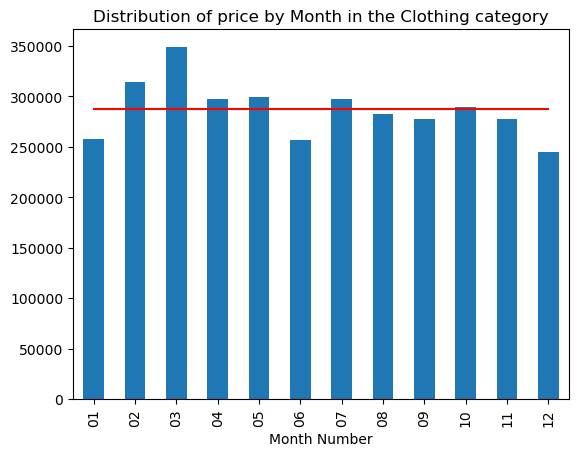

In [85]:
# Seasonal changes in total price and total quantity in the Clothing category

# Comparing the observed distribution of price in the Clothing category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Clothing")].groupby("Month Number")["USD Price"].sum()

comparison_w_equal_distribution(df, "Distribution of price by Month in the Clothing category")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the price for months is not random

**March, April, May and July** show bigger than average purchases, while **August, November and December** show lower than average purchases. **December** can be considered as the *sales month*onthonth

Statistic = 2122.403749322178, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



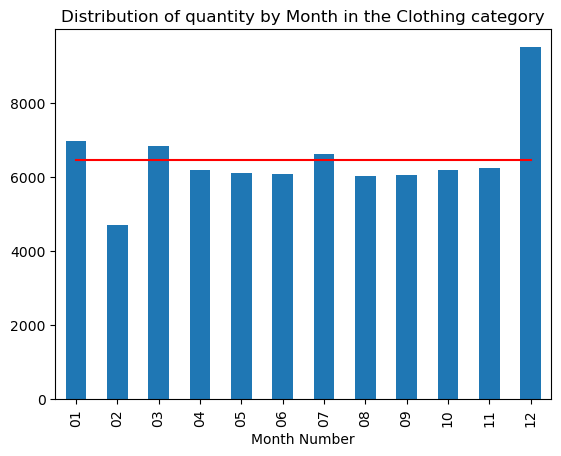

In [86]:
#Comparing the observed distribution of quantity in the Clothing category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Clothing")].groupby("Month Number")["quantity"].sum()

comparison_w_equal_distribution(df, "Distribution of quantity by Month in the Clothing category")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the quantity for months is not random

**February** shows lower than average quantity, while **December** shows higher than average quantity. **December** can be considered as the *sales month*, while marketing specialists should pay attention at **February**

### Seasonal changes in total price and total quantity in the Cosmetics category

Statistic = 1990.7847310151237, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



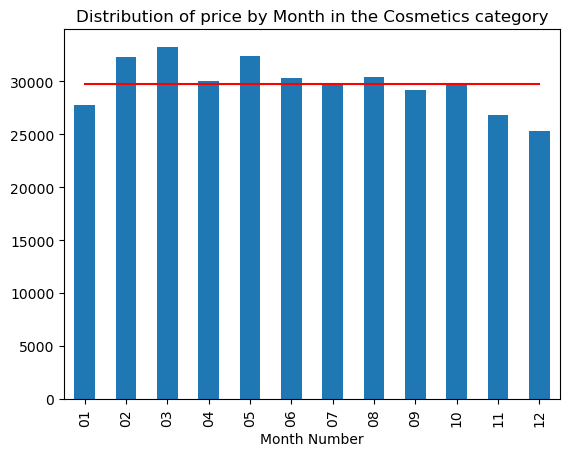

In [87]:
# Comparing the observed distribution of price in the Cosmetics category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Cosmetics")].groupby("Month Number")["USD Price"].sum()

comparison_w_equal_distribution(df, "Distribution of price by Month in the Cosmetics category")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the price for months is not random

**March and May** show bigger than average purchases, while **November and December** show lower than average purchases. **November and December** can be considered as the *sales months*

Statistic = 576.8627348369877, p-value = 1.2416185744536918e-116
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



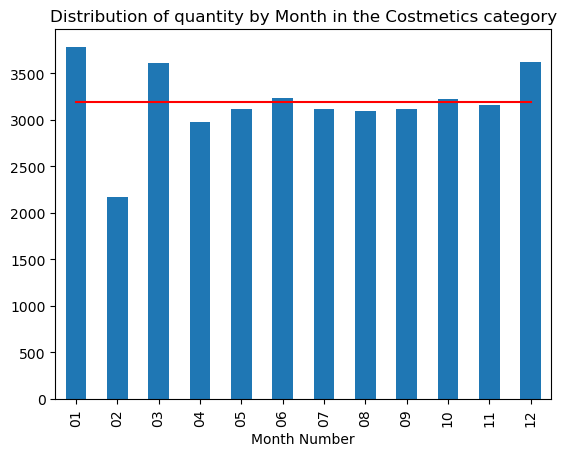

In [88]:
# Comparing the observed distribution of quantity in the Cosmetics category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Cosmetics")].groupby("Month Number")["quantity"].sum()

comparison_w_equal_distribution(df, "Distribution of quantity by Month in the Costmetics category")

*Red line* is the equal distribution

`pvalue` is almost 0, we should reject H0; therefore, the difference in the quantity for months is not random

**February** shows lower than average quantity, while **January, February and December** show higher than average quantity. **January, February and December** can be considered as the *sales months*, while marketing specialists should pay attention at **February**

### Seasonal changes in total price and total quantity in the Food & Beverage category

Statistic = 1159.225988132577, p-value = 9.906467639291519e-242
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



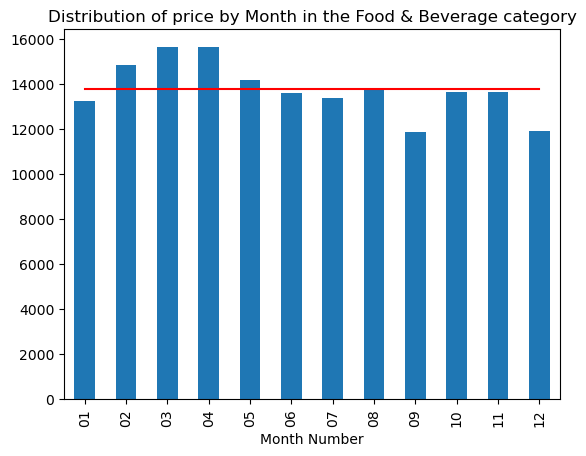

In [89]:
# Comparing the observed distribution of price in the Food & Beverage category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Food & Beverage")].groupby("Month Number")["USD Price"].sum()

comparison_w_equal_distribution(df, "Distribution of price by Month in the Food & Beverage category")

*Red line* is the equal distribution

`pvalue` is almost 0, we should reject H0; therefore, the difference in the price for months is not random

**April and May** show bigger than average purchases, while **January and December** show lower than average purchases. **January and December** can be considered as the *sales month*

Statistic = 1143.7744939628074, p-value = 2.1134367015391462e-238
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



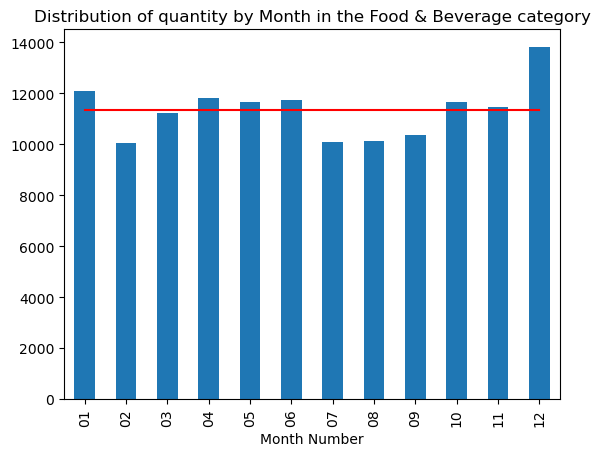

In [90]:
# Comparing the observed distribution of quantity in the Food & Beverage category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Food & Beverage")].groupby("Month Number")["quantity"].sum()

comparison_w_equal_distribution(df, "Distribution of quantity by Month in the Food & Beverage category")

*Red line* is the equal distribution

`pvalue` is almost 0, we should reject H0; therefore, the difference in the quantity for months is not random

**February, July, August and September** show lower than average quantity, while **December** shows higher than average quantity. **December** can be considered as the *sales month*, while marketing specialists should pay attention at **February, July, August and September**

### Seasonal changes in total price and total quantity in the Souvenir category

Statistic = 128.20427131930919, p-value = 4.017402581044844e-22
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



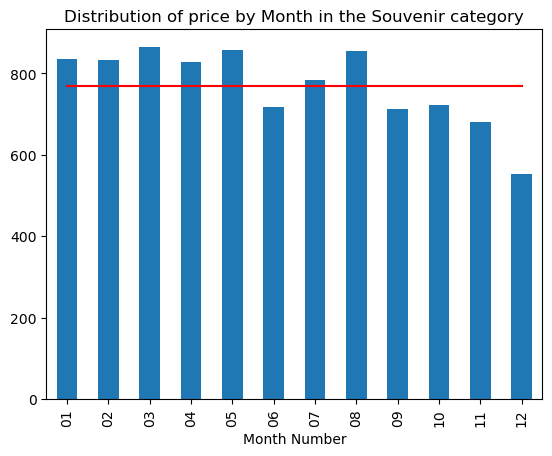

In [91]:
# Comparing the observed distribution of price in the Souvenir category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Souvenir")].groupby("Month Number")["USD Price"].sum()

comparison_w_equal_distribution(df, "Distribution of price by Month in the Souvenir category")

*Red line* is the equal distribution

`pvalue` is almost 0, we should reject H0; therefore, the difference in the price for months is not random

**March and April** show bigger than average purchases, while **December** shows lower than average purchases. **December** can be considered as the *sales month*

Statistic = 2526.542869593638, p-value = 0.0
H0 should be rejected, indicating that there are statistically significant differences in the observed distribution comparing to the equal distribution.



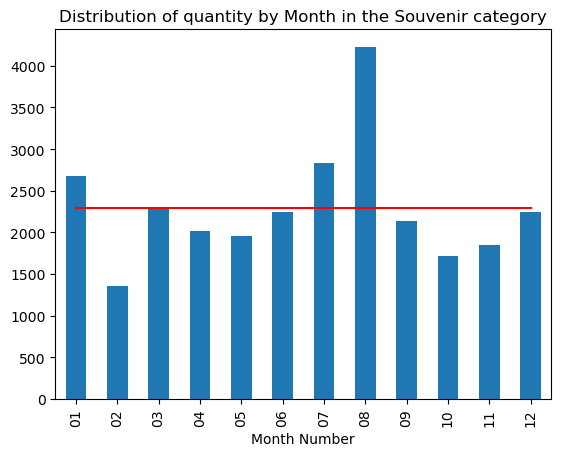

In [92]:
# Comparing the observed distribution of quantity in the Souvenir category by month with the equal distribution
df = full_years_df[(full_years_df["category"] == "Souvenir")].groupby("Month Number")["quantity"].sum()

comparison_w_equal_distribution(df, "Distribution of quantity by Month in the Souvenir category")

*Red line* is the equal distribution

`pvalue` = 0, we should reject H0; therefore, the difference in the quantity for months is not random

**February, May, October and November** show lower than average quantity, while **December** shows higher than average quantity. **January, July and especially August** can be considered as the *sales month*, **August** can be explained by a touristic season, while marketing specialists should pay attention at **February, May, October and November**